In [1]:
import meep as mp
import meep.adjoint as mpa
from meep import Animate2D
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from meep.materials import Ag
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
#from meep.materials import c-Si


os.makedirs(f'PICTURE',exist_ok=True)
mp.verbosity(0)
TiO2 = mp.Medium(index=2.6)
SiO2 = mp.Medium(index=1.44)
Si = mp.Medium(index=3.4)
Air = mp.Medium(index=1)

In [2]:
resolution = 100
design_region_resolution = int(resolution)

design_region_x_width  = 1   #100 nm
design_region_y_height = 1   #100 nm
design_region_z_height = 0.03  #20 nm or 10nm

pml_size = 1.0
pml_layers = [mp.PML(pml_size,direction=mp.Z)]

Sz_size = 0.6
Sx = design_region_x_width
Sy = design_region_y_height 
Sz = 2 * pml_size + design_region_z_height + Sz_size
cell_size = mp.Vector3(Sx, Sy, Sz)

wavelengths = np.array([1.55])     # wavelengths = np.array([1.5 ,1.55, 1.6])
frequencies = np.array([1 / 1.55])

nf = 1                 #3 #wavelengths Number

minimum_length = 0.01  # minimum length scale (microns)
eta_i = 0.5            # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55           # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e      # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

Source_distance = -0.2

fcen   = 1 / 1.55
width  = 0.2  
fwidth = width * fcen
source_center = mp.Vector3(0,0,Source_distance)  
source_size   = mp.Vector3(design_region_x_width, design_region_y_height, 0)
src    = mp.GaussianSource(frequency=fcen, fwidth=fwidth, is_integrated=True)
source = [mp.Source(src, component=mp.Ey, size=source_size, center=source_center)]   

Nx = int(design_region_resolution * design_region_x_width) + 1
Ny = int(design_region_resolution * design_region_y_height) + 1
Nz = 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny, Nz), Air, Si, grid_type="U_MEAN")
design_region    = mpa.DesignRegion(
            design_variables,
            volume=mp.Volume(
            center=mp.Vector3(0,0,0),
            size=mp.Vector3(design_region_x_width, design_region_y_height, design_region_z_height),
            ),
)

def mapping(x, eta, beta):
    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_x_width,
        design_region_y_height,
        design_region_resolution,
    )
    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)
    projected_field = (npa.fliplr(projected_field) + projected_field) / 2
    projected_field = (npa.flipud(projected_field) + projected_field) / 2  # left-right symmetry    
    
    return projected_field.flatten()


geometry = [mp.Block(center=design_region.center, size=design_region.size, material=design_variables)]

kpoint = mp.Vector3()
sim = mp.Simulation(
    cell_size        = cell_size,
    boundary_layers  = pml_layers,
    geometry         = geometry,
    sources          = source,
    default_material = Air,
    k_point          = kpoint,
    symmetries       = [mp.Mirror(direction=mp.X)],
    resolution       = resolution,
    extra_materials  = [Ag],       # Introducing metal complex terms
)
#---------------------------------------------------------------------------------------------------#


#-----------------[4]---------------------------------#
monitor_position   = mp.Vector3(0, 0, 0)       # Focus position
monitor_size       = mp.Vector3(0.01,0.01,0.01)     # Focus Size//////0.11
FourierFields_x    = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ex,yee_grid=True)
FourierFields_y    = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ey,yee_grid=True)
FourierFields_z    = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True)
ob_list            = [FourierFields_x,FourierFields_y,FourierFields_z]


def J(fields_x,fields_y,fields_z):
    ET_x = npa.abs(fields_x) ** 2
    ET_y = npa.abs(fields_y) ** 2
    ET_z = npa.abs(fields_z) ** 2
    ET = npa.sqrt( npa.mean(ET_x) + npa.mean(ET_y) + npa.mean(ET_z) )  
    return ET


opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    decimation_factor = 1 ,           # KEY BUG!!
    maximum_run_time=50,
)

[0.5 0.5 0.5 ... 0.5 0.5 0.5]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


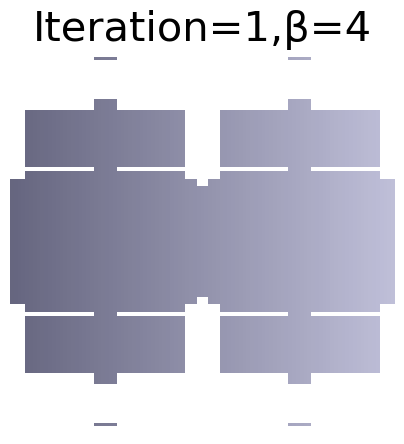

[0.50010818 0.50007542 0.50006207 ... 0.50006207 0.50007542 0.50010818]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


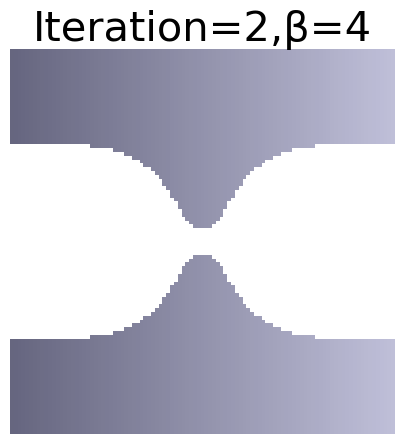

[0.50129587 0.50090454 0.50074488 ... 0.50074488 0.50090454 0.50129587]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


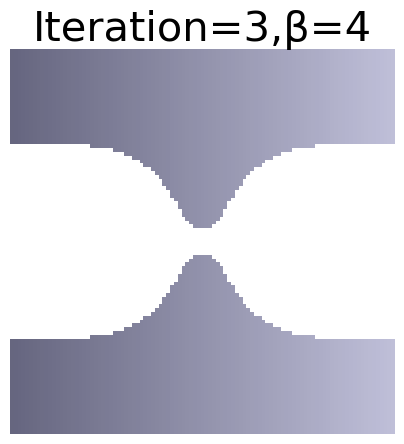

[0.53385951 0.52436295 0.5203403  ... 0.5203403  0.52436295 0.53385951]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


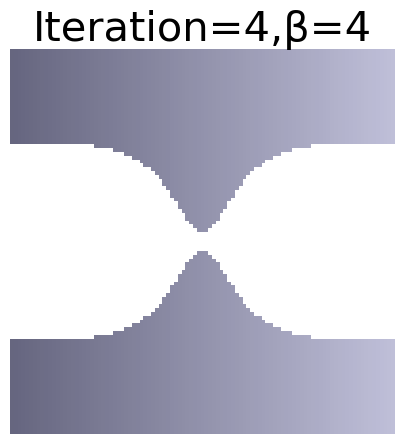

[1. 1. 1. ... 1. 1. 1.]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


/home/ming/anaconda3/envs/mp/lib/python3.8/site-packages/meep/geom.py:588: UserWarning: The weights parameter of MaterialGrid must be in the range [0,1].
  warnings.warn(


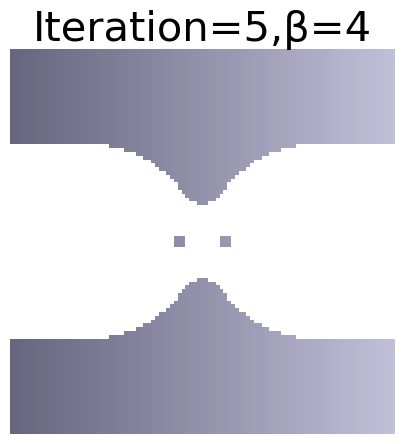

[0.97835619 0.93251851 0.91069727 ... 0.91069727 0.93251851 0.97835619]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


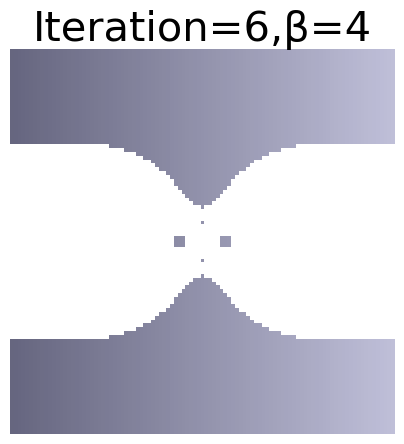

[0.70821471 0.66516386 0.64686584 ... 0.64686584 0.66516386 0.70821471]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


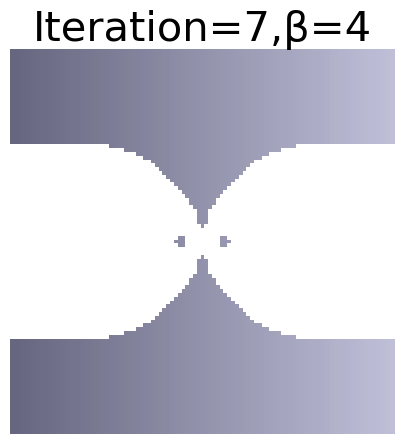

[0.56189944 0.54489737 0.53805762 ... 0.53805762 0.54489737 0.56189944]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


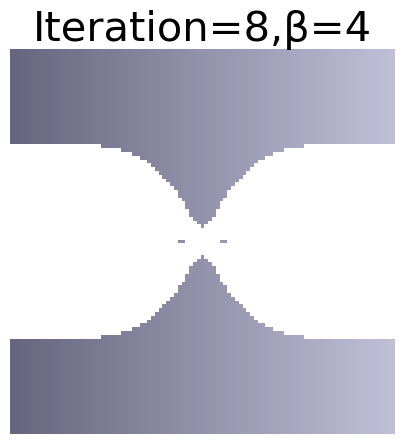

[0.53687002 0.52652568 0.52219299 ... 0.52219299 0.52652568 0.53687002]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


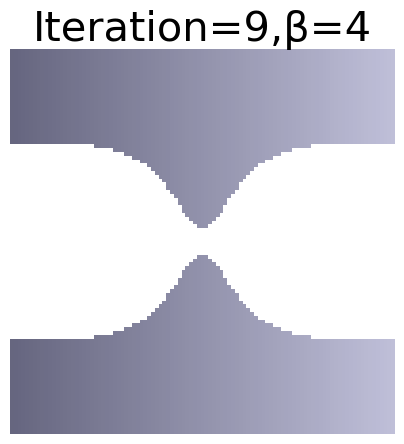

[0.53431662 0.52469068 0.52062084 ... 0.52062084 0.52469068 0.53431662]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


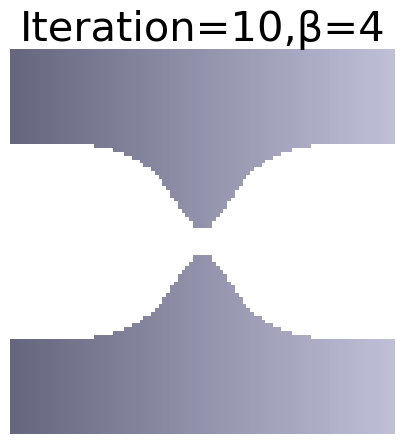

[0.53394728 0.52442586 0.52039414 ... 0.52039414 0.52442586 0.53394728]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


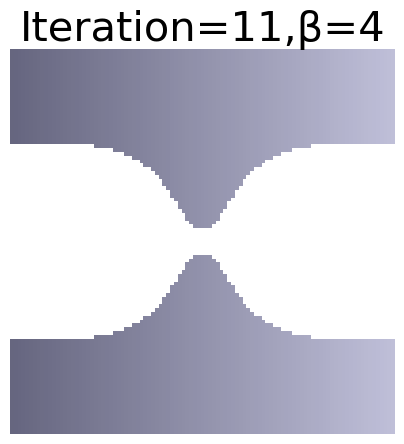

[0.53388036 0.52437789 0.52035309 ... 0.52035309 0.52437789 0.53388036]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


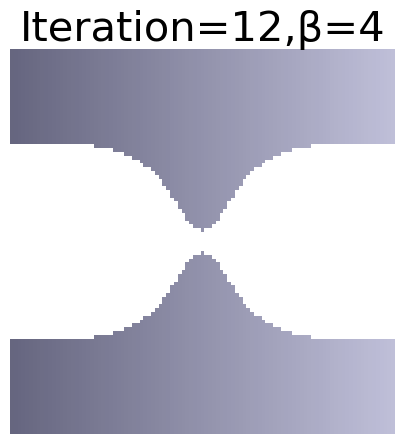

[0.53389941 0.52439154 0.52036474 ... 0.52036474 0.52439154 0.53389941]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


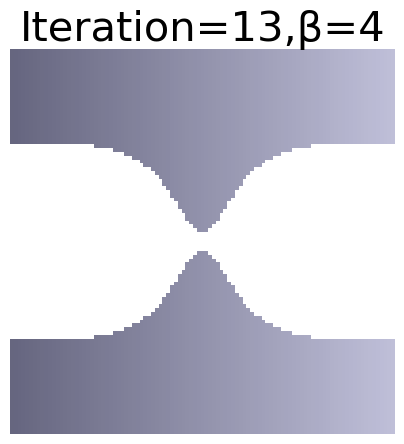

[0.53388705 0.52438269 0.52035718 ... 0.52035718 0.52438269 0.53388705]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


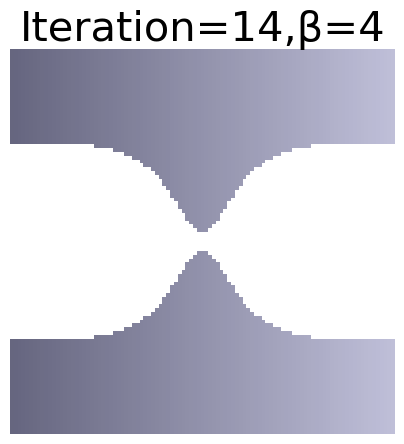

[0.53388285 0.52437968 0.52035461 ... 0.52035461 0.52437968 0.53388285]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


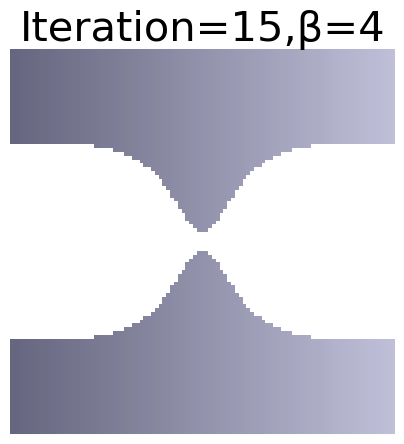

[0.53388036 0.52437789 0.52035309 ... 0.52035309 0.52437789 0.53388036]
2
0.5
8
[0.53388036 0.52437789 0.52035309 ... 0.52035309 0.52437789 0.53388036]


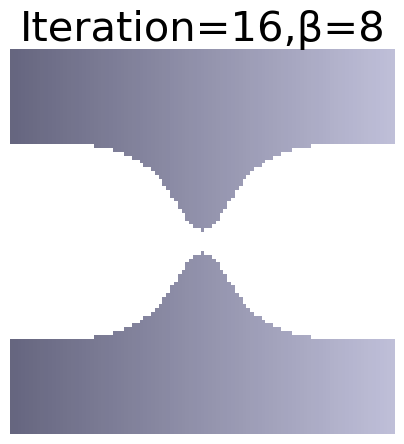

[0.54024178 0.52907913 0.52450856 ... 0.52450856 0.52907913 0.54024178]
2
0.5
8
[0.53388036 0.52437789 0.52035309 ... 0.52035309 0.52437789 0.53388036]


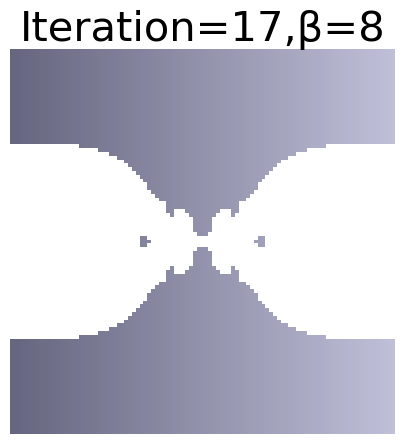

[0.54082845 0.52951513 0.52490003 ... 0.52490003 0.52951513 0.54082845]
2
0.5
8
[0.53388036 0.52437789 0.52035309 ... 0.52035309 0.52437789 0.53388036]


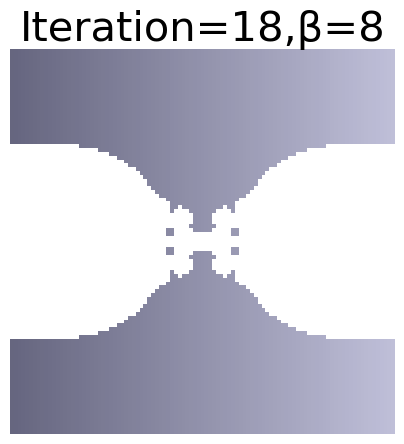

[0.54035957 0.52916662 0.52458711 ... 0.52458711 0.52916662 0.54035957]
2
0.5
8
[0.53388036 0.52437789 0.52035309 ... 0.52035309 0.52437789 0.53388036]


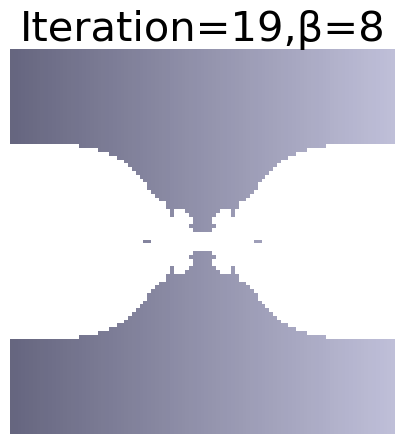

[0.54042973 0.52921862 0.52463356 ... 0.52463356 0.52921862 0.54042973]
2
0.5
8
[0.53388036 0.52437789 0.52035309 ... 0.52035309 0.52437789 0.53388036]


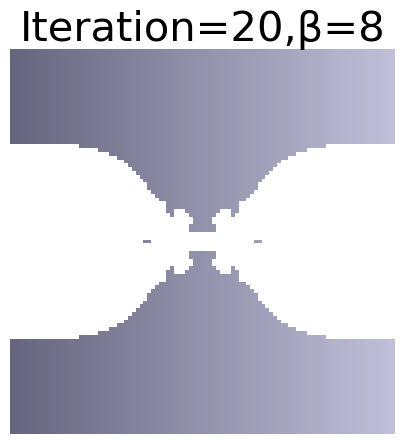

[0.54044511 0.52923005 0.52464382 ... 0.52464382 0.52923005 0.54044511]
2
0.5
8
[0.53388036 0.52437789 0.52035309 ... 0.52035309 0.52437789 0.53388036]


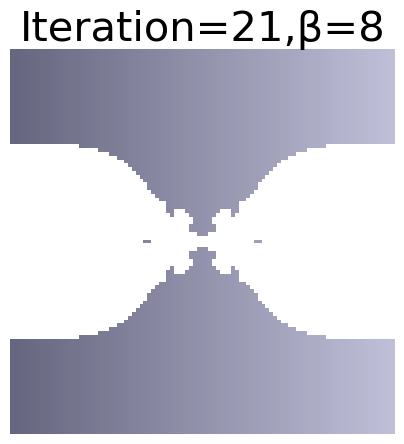

[0.54043479 0.52922238 0.52463693 ... 0.52463693 0.52922238 0.54043479]
2
0.5
8
[0.53388036 0.52437789 0.52035309 ... 0.52035309 0.52437789 0.53388036]


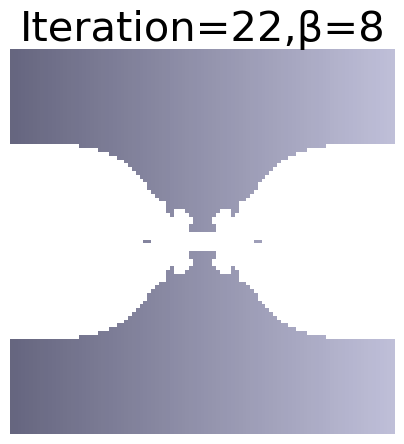

[0.54043156 0.52921999 0.52463478 ... 0.52463478 0.52921999 0.54043156]
2
0.5
8
[0.53388036 0.52437789 0.52035309 ... 0.52035309 0.52437789 0.53388036]


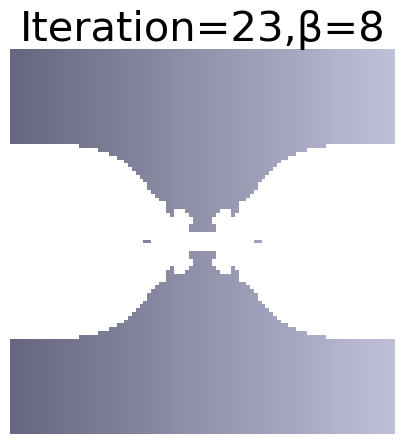

[0.54043044 0.52921915 0.52463404 ... 0.52463404 0.52921915 0.54043044]
2
0.5
8
[0.53388036 0.52437789 0.52035309 ... 0.52035309 0.52437789 0.53388036]


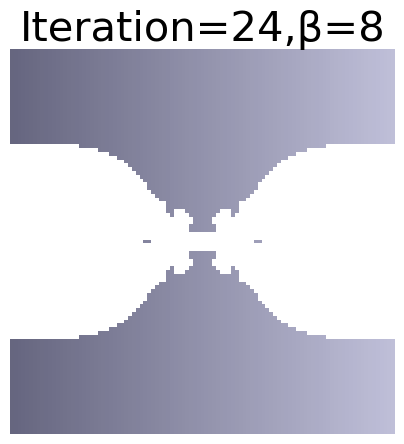

[0.54043002 0.52921884 0.52463375 ... 0.52463375 0.52921884 0.54043002]
2
0.5
8
[0.53388036 0.52437789 0.52035309 ... 0.52035309 0.52437789 0.53388036]


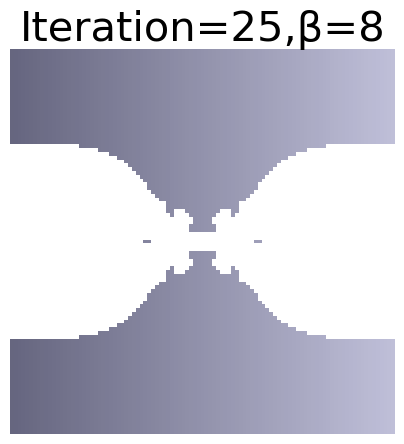

[0.54042985 0.52921871 0.52463364 ... 0.52463364 0.52921871 0.54042985]
2
0.5
8
[0.53388036 0.52437789 0.52035309 ... 0.52035309 0.52437789 0.53388036]


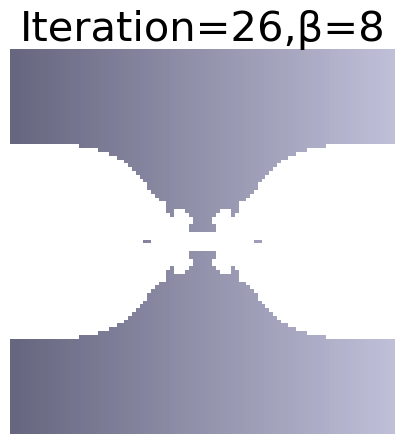

[0.54042978 0.52921866 0.52463359 ... 0.52463359 0.52921866 0.54042978]
2
0.5
8
[0.53388036 0.52437789 0.52035309 ... 0.52035309 0.52437789 0.53388036]


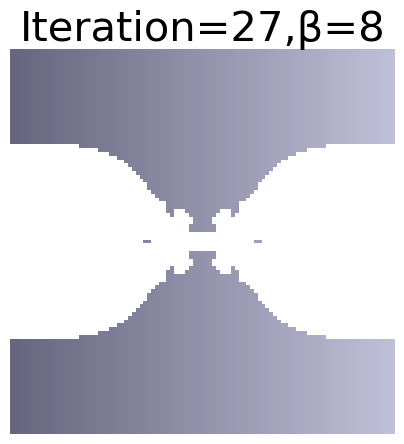

[0.54042975 0.52921864 0.52463357 ... 0.52463357 0.52921864 0.54042975]
2
0.5
8
[0.53388036 0.52437789 0.52035309 ... 0.52035309 0.52437789 0.53388036]


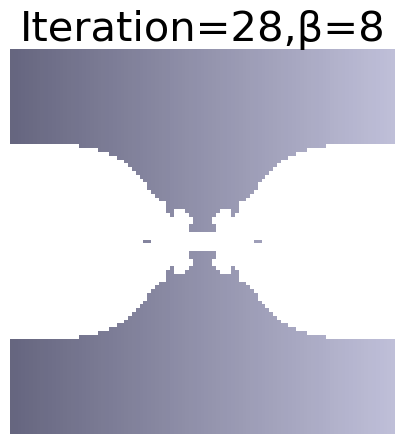

[0.54042974 0.52921863 0.52463356 ... 0.52463356 0.52921863 0.54042974]
2
0.5
8
[0.53388036 0.52437789 0.52035309 ... 0.52035309 0.52437789 0.53388036]


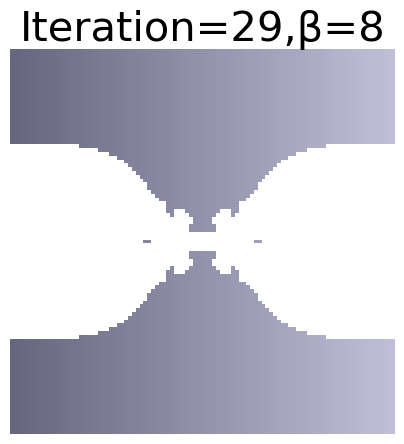

[0.54042973 0.52921863 0.52463356 ... 0.52463356 0.52921863 0.54042973]
2
0.5
8
[0.53388036 0.52437789 0.52035309 ... 0.52035309 0.52437789 0.53388036]


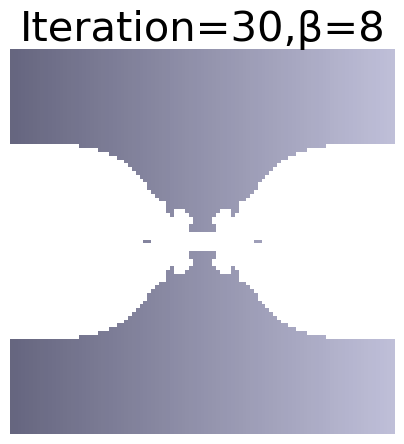

[0.54042973 0.52921862 0.52463356 ... 0.52463356 0.52921862 0.54042973]
2
0.5
16
[0.54042973 0.52921862 0.52463356 ... 0.52463356 0.52921862 0.54042973]


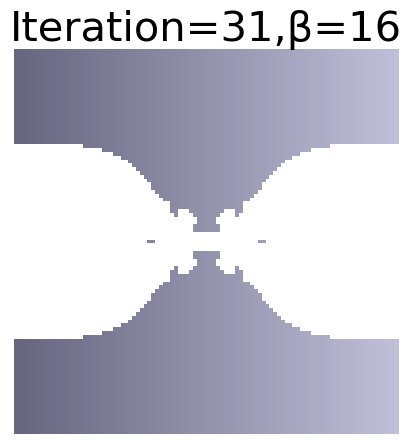

[0.55476208 0.5406749  0.53571353 ... 0.53571353 0.5406749  0.55476208]
2
0.5
16
[0.54042973 0.52921862 0.52463356 ... 0.52463356 0.52921862 0.54042973]


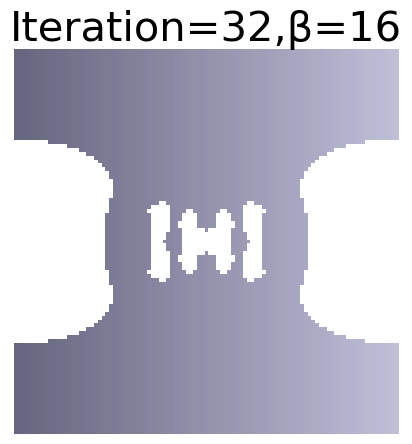

[0.54193964 0.53041288 0.525787   ... 0.525787   0.53041288 0.54193964]
2
0.5
16
[0.54042973 0.52921862 0.52463356 ... 0.52463356 0.52921862 0.54042973]


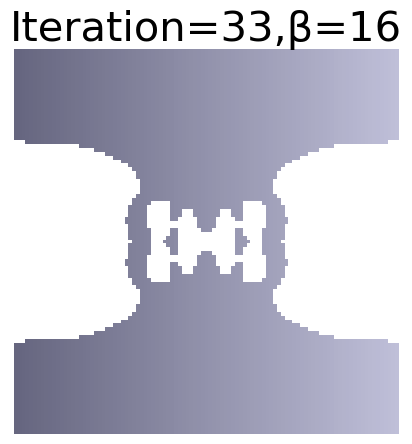

[0.540669   0.52940767 0.52481612 ... 0.52481612 0.52940767 0.540669  ]
2
0.5
16
[0.54042973 0.52921862 0.52463356 ... 0.52463356 0.52921862 0.54042973]


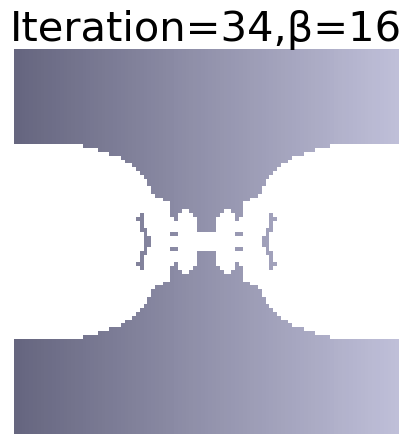

[0.54049241 0.52926814 0.52468138 ... 0.52468138 0.52926814 0.54049241]
2
0.5
16
[0.54042973 0.52921862 0.52463356 ... 0.52463356 0.52921862 0.54042973]


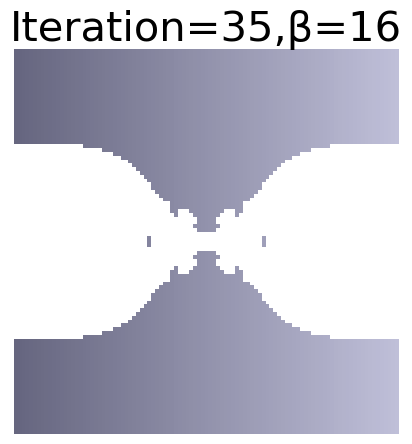

[0.54052448 0.5292935  0.5247059  ... 0.5247059  0.5292935  0.54052448]
2
0.5
16
[0.54042973 0.52921862 0.52463356 ... 0.52463356 0.52921862 0.54042973]


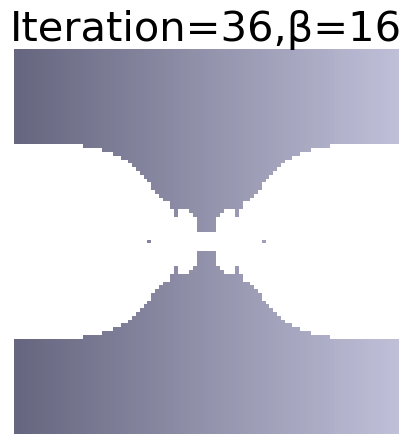

[0.54050307 0.52927657 0.52468952 ... 0.52468952 0.52927657 0.54050307]
2
0.5
16
[0.54042973 0.52921862 0.52463356 ... 0.52463356 0.52921862 0.54042973]


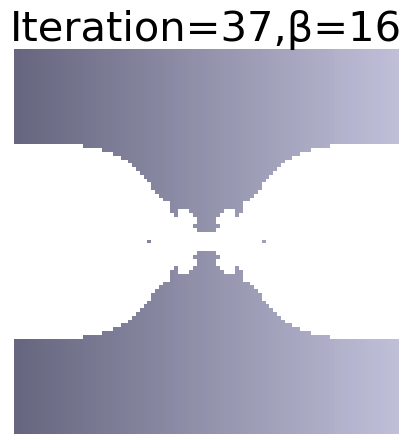

[0.54049665 0.52927149 0.52468462 ... 0.52468462 0.52927149 0.54049665]
2
0.5
16
[0.54042973 0.52921862 0.52463356 ... 0.52463356 0.52921862 0.54042973]


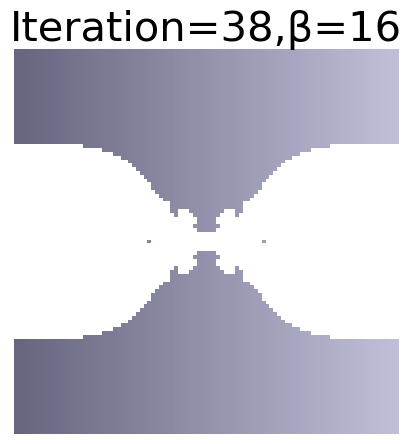

[0.54049398 0.52926938 0.52468257 ... 0.52468257 0.52926938 0.54049398]
2
0.5
16
[0.54042973 0.52921862 0.52463356 ... 0.52463356 0.52921862 0.54042973]


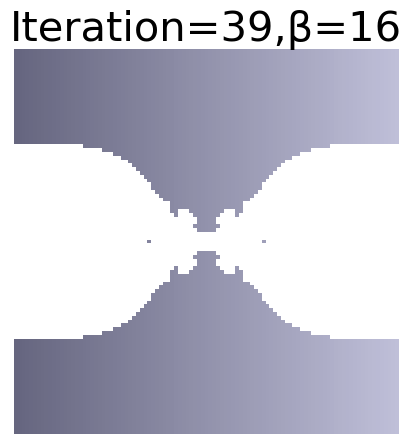

[0.54049298 0.52926859 0.52468181 ... 0.52468181 0.52926859 0.54049298]
2
0.5
16
[0.54042973 0.52921862 0.52463356 ... 0.52463356 0.52921862 0.54042973]


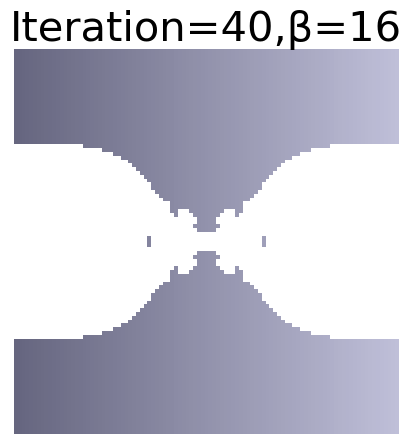

[0.5404926  0.52926829 0.52468152 ... 0.52468152 0.52926829 0.5404926 ]
2
0.5
16
[0.54042973 0.52921862 0.52463356 ... 0.52463356 0.52921862 0.54042973]


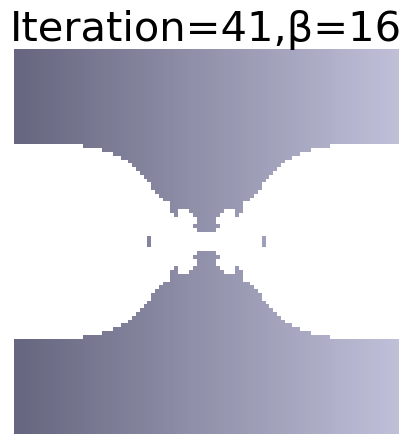

[0.54049247 0.52926819 0.52468142 ... 0.52468142 0.52926819 0.54049247]
2
0.5
16
[0.54042973 0.52921862 0.52463356 ... 0.52463356 0.52921862 0.54042973]


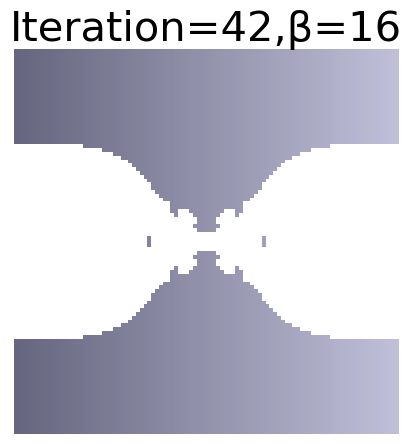

[0.54049243 0.52926816 0.52468139 ... 0.52468139 0.52926816 0.54049243]
2
0.5
16
[0.54042973 0.52921862 0.52463356 ... 0.52463356 0.52921862 0.54042973]


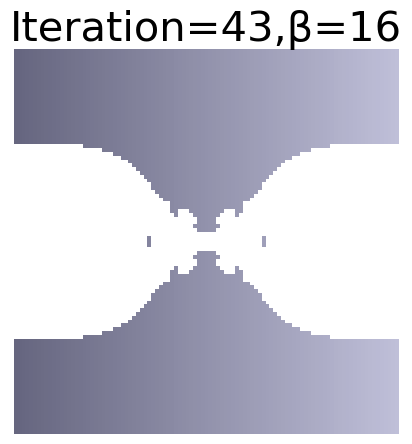

[0.54049242 0.52926815 0.52468138 ... 0.52468138 0.52926815 0.54049242]
2
0.5
16
[0.54042973 0.52921862 0.52463356 ... 0.52463356 0.52921862 0.54042973]


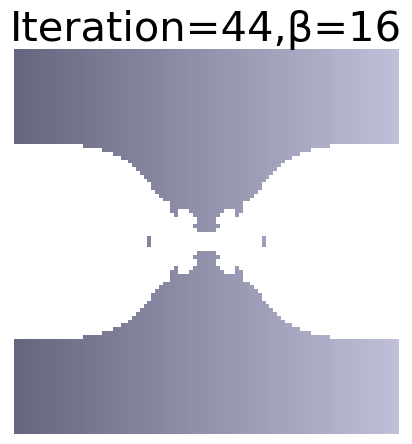

[0.54049241 0.52926814 0.52468138 ... 0.52468138 0.52926814 0.54049241]
2
0.5
16
[0.54042973 0.52921862 0.52463356 ... 0.52463356 0.52921862 0.54042973]


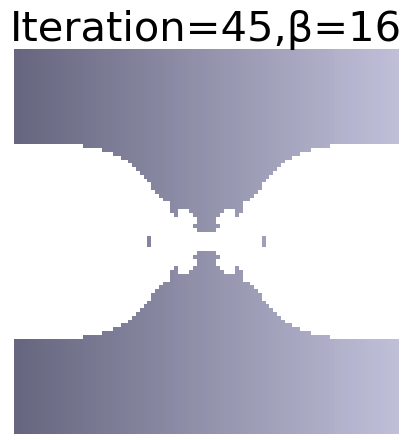

[0.54049241 0.52926814 0.52468138 ... 0.52468138 0.52926814 0.54049241]
2
0.5
32
[0.54049241 0.52926814 0.52468138 ... 0.52468138 0.52926814 0.54049241]


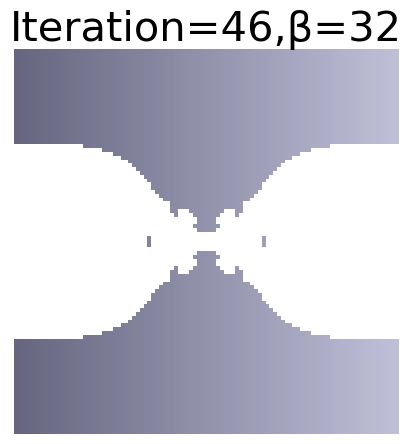

[0.5424733  0.53106779 0.5267043  ... 0.5267043  0.53106779 0.5424733 ]
2
0.5
32
[0.54049241 0.52926814 0.52468138 ... 0.52468138 0.52926814 0.54049241]


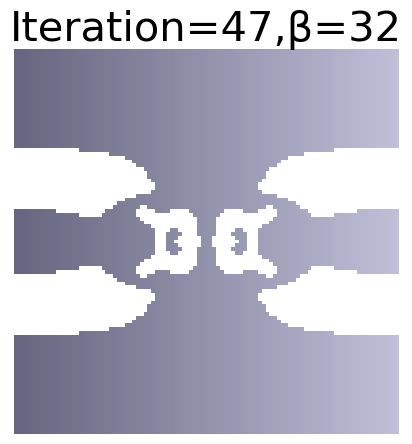

[0.54069192 0.52944928 0.52488515 ... 0.52488515 0.52944928 0.54069192]
2
0.5
32
[0.54049241 0.52926814 0.52468138 ... 0.52468138 0.52926814 0.54049241]


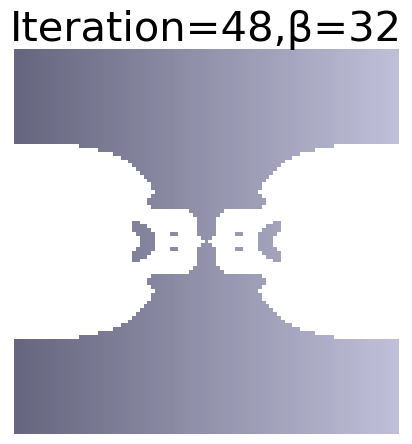

[0.54051238 0.52928627 0.52470177 ... 0.52470177 0.52928627 0.54051238]
2
0.5
32
[0.54049241 0.52926814 0.52468138 ... 0.52468138 0.52926814 0.54049241]


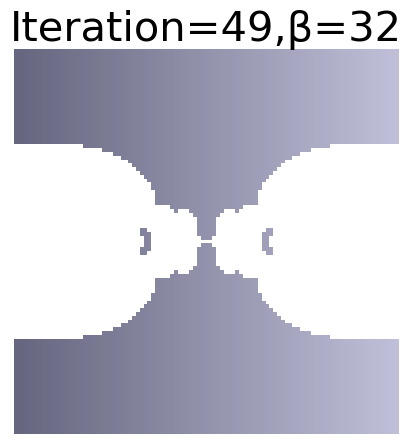

[0.54049441 0.52926995 0.52468342 ... 0.52468342 0.52926995 0.54049441]
2
0.5
32
[0.54049241 0.52926814 0.52468138 ... 0.52468138 0.52926814 0.54049241]


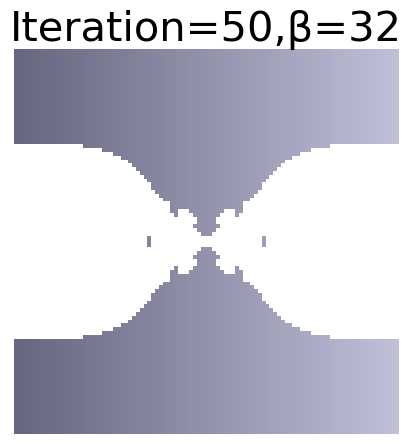

[0.54049568 0.52927111 0.52468472 ... 0.52468472 0.52927111 0.54049568]
2
0.5
32
[0.54049241 0.52926814 0.52468138 ... 0.52468138 0.52926814 0.54049241]


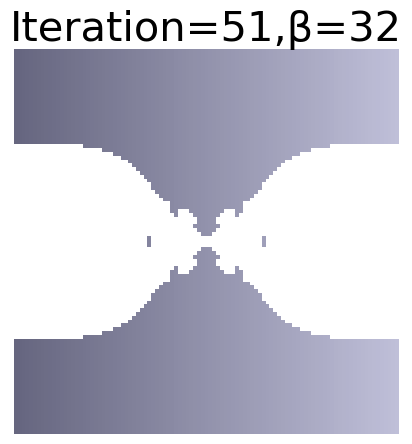

[0.5404963  0.52927167 0.52468535 ... 0.52468535 0.52927167 0.5404963 ]
2
0.5
32
[0.54049241 0.52926814 0.52468138 ... 0.52468138 0.52926814 0.54049241]


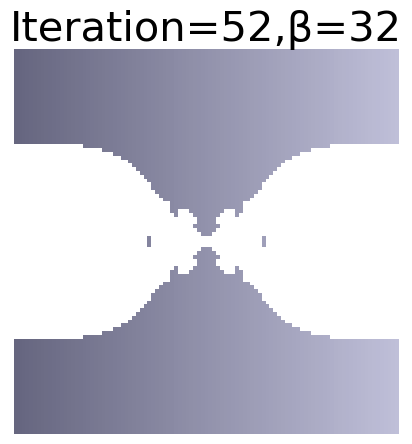

[0.5404959  0.52927131 0.52468495 ... 0.52468495 0.52927131 0.5404959 ]
2
0.5
32
[0.54049241 0.52926814 0.52468138 ... 0.52468138 0.52926814 0.54049241]


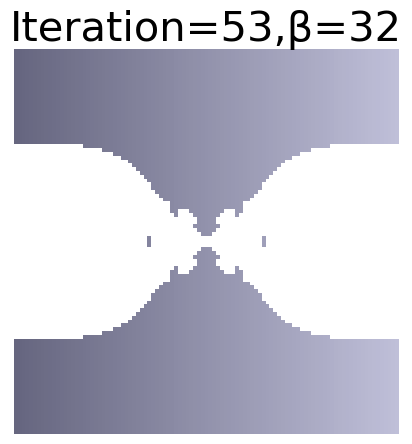

[0.54049577 0.52927119 0.52468481 ... 0.52468481 0.52927119 0.54049577]
2
0.5
32
[0.54049241 0.52926814 0.52468138 ... 0.52468138 0.52926814 0.54049241]


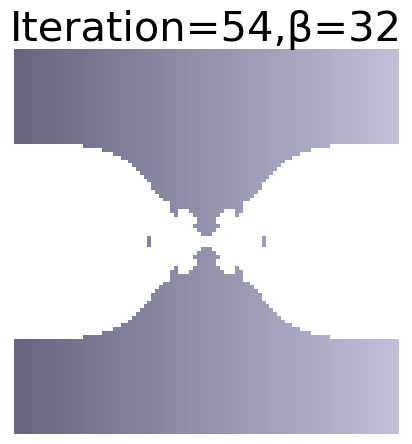

[0.54049572 0.52927115 0.52468476 ... 0.52468476 0.52927115 0.54049572]
2
0.5
32
[0.54049241 0.52926814 0.52468138 ... 0.52468138 0.52926814 0.54049241]


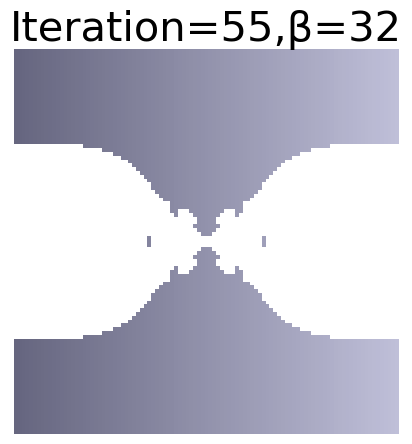

[0.54049574 0.52927116 0.52468478 ... 0.52468478 0.52927116 0.54049574]
2
0.5
32
[0.54049241 0.52926814 0.52468138 ... 0.52468138 0.52926814 0.54049241]


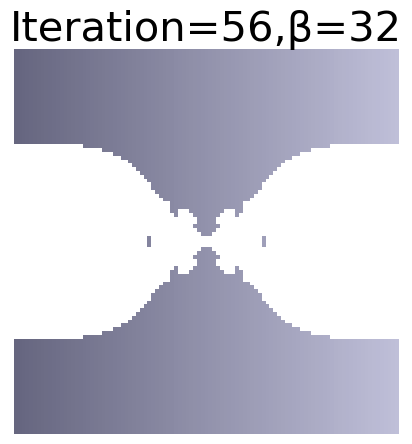

[0.54049575 0.52927117 0.52468479 ... 0.52468479 0.52927117 0.54049575]
2
0.5
32
[0.54049241 0.52926814 0.52468138 ... 0.52468138 0.52926814 0.54049241]


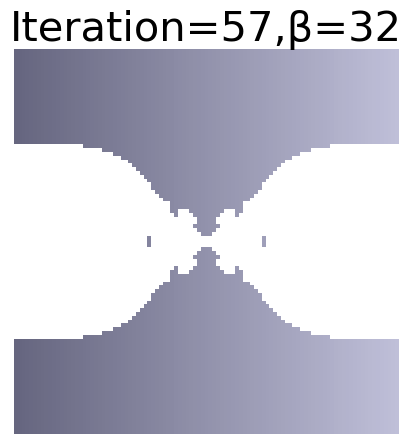

[0.54049575 0.52927118 0.52468479 ... 0.52468479 0.52927118 0.54049575]
2
0.5
32
[0.54049241 0.52926814 0.52468138 ... 0.52468138 0.52926814 0.54049241]


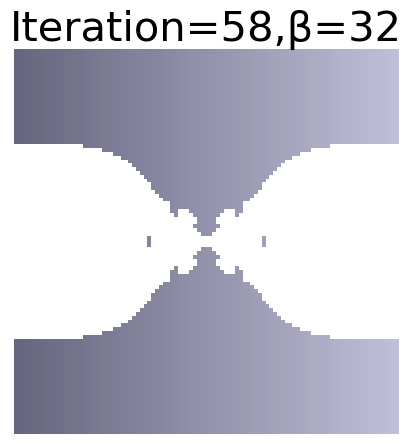

[0.54049576 0.52927118 0.52468479 ... 0.52468479 0.52927118 0.54049576]
2
0.5
32
[0.54049241 0.52926814 0.52468138 ... 0.52468138 0.52926814 0.54049241]


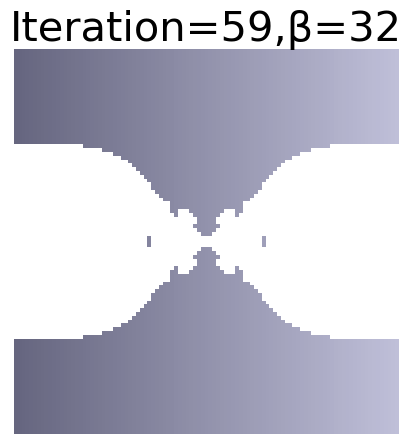

[0.54049576 0.52927118 0.5246848  ... 0.5246848  0.52927118 0.54049576]
2
0.5
32
[0.54049241 0.52926814 0.52468138 ... 0.52468138 0.52926814 0.54049241]


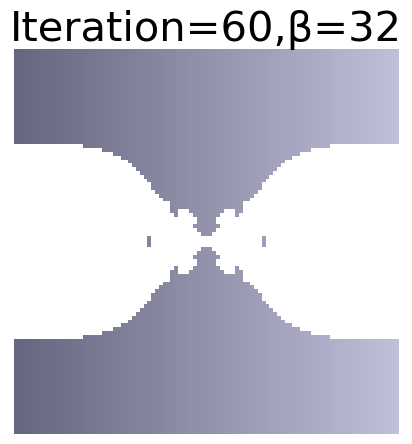

[0.54049576 0.52927118 0.5246848  ... 0.5246848  0.52927118 0.54049576]
2
0.5
64
[0.54049576 0.52927118 0.5246848  ... 0.5246848  0.52927118 0.54049576]


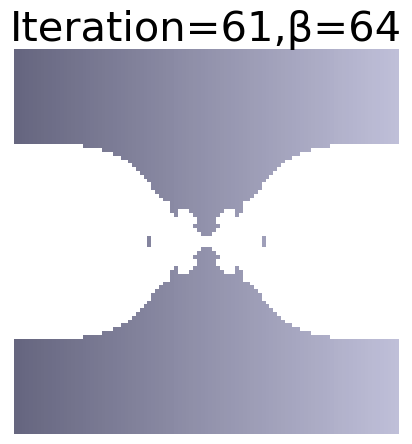

[0.54228693 0.53147964 0.52791479 ... 0.52791479 0.53147964 0.54228693]
2
0.5
64
[0.54049576 0.52927118 0.5246848  ... 0.5246848  0.52927118 0.54049576]


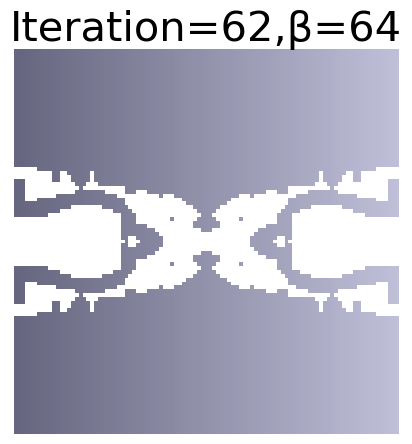

[0.54067604 0.52949379 0.52501158 ... 0.52501158 0.52949379 0.54067604]
2
0.5
64
[0.54049576 0.52927118 0.5246848  ... 0.5246848  0.52927118 0.54049576]


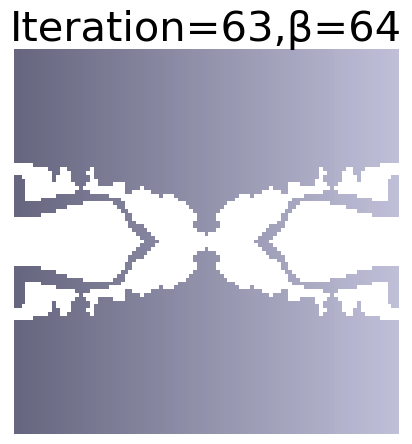

[0.5405256  0.52930804 0.52473892 ... 0.52473892 0.52930804 0.5405256 ]
2
0.5
64
[0.54049576 0.52927118 0.5246848  ... 0.5246848  0.52927118 0.54049576]


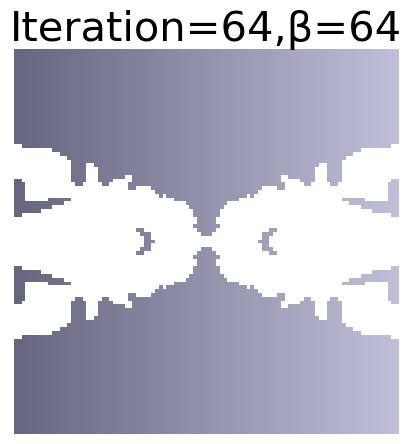

[0.54053323 0.52931742 0.52475262 ... 0.52475262 0.52931742 0.54053323]
2
0.5
64
[0.54049576 0.52927118 0.5246848  ... 0.5246848  0.52927118 0.54049576]


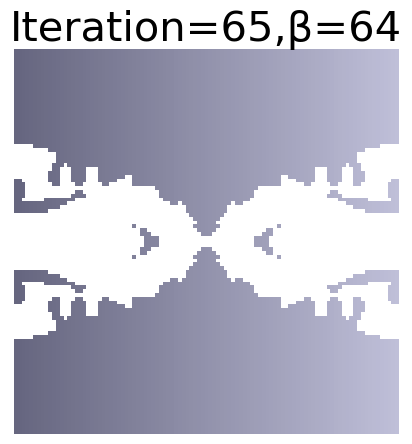

[0.54052706 0.52930983 0.52474153 ... 0.52474153 0.52930983 0.54052706]
2
0.5
64
[0.54049576 0.52927118 0.5246848  ... 0.5246848  0.52927118 0.54049576]


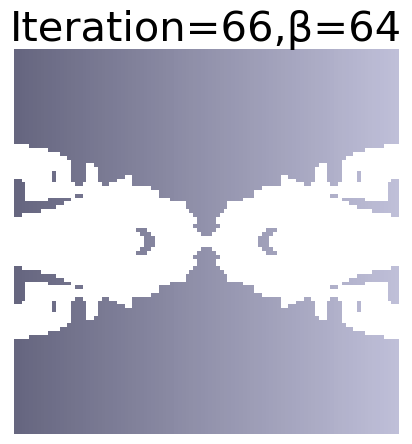

[0.54052602 0.52930855 0.52473967 ... 0.52473967 0.52930855 0.54052602]
2
0.5
64
[0.54049576 0.52927118 0.5246848  ... 0.5246848  0.52927118 0.54049576]


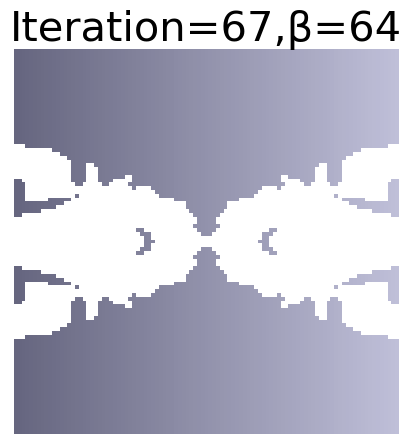

[0.54052575 0.52930822 0.52473919 ... 0.52473919 0.52930822 0.54052575]
2
0.5
64
[0.54049576 0.52927118 0.5246848  ... 0.5246848  0.52927118 0.54049576]


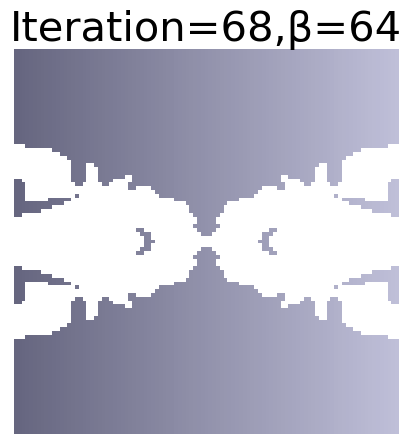

[0.54052566 0.52930811 0.52473903 ... 0.52473903 0.52930811 0.54052566]
2
0.5
64
[0.54049576 0.52927118 0.5246848  ... 0.5246848  0.52927118 0.54049576]


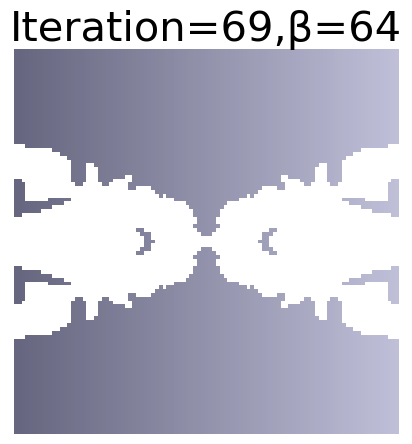

[0.54052563 0.52930807 0.52473897 ... 0.52473897 0.52930807 0.54052563]
2
0.5
64
[0.54049576 0.52927118 0.5246848  ... 0.5246848  0.52927118 0.54049576]


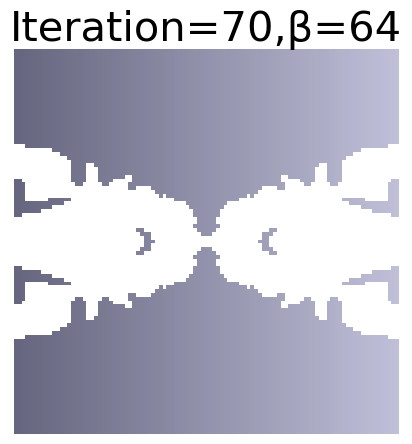

[0.54052561 0.52930805 0.52473894 ... 0.52473894 0.52930805 0.54052561]
2
0.5
64
[0.54049576 0.52927118 0.5246848  ... 0.5246848  0.52927118 0.54049576]


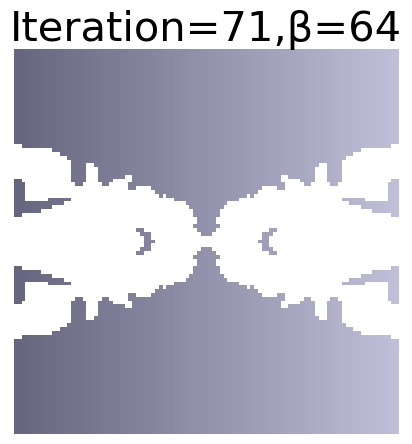

[0.54052562 0.52930806 0.52473895 ... 0.52473895 0.52930806 0.54052562]
2
0.5
64
[0.54049576 0.52927118 0.5246848  ... 0.5246848  0.52927118 0.54049576]


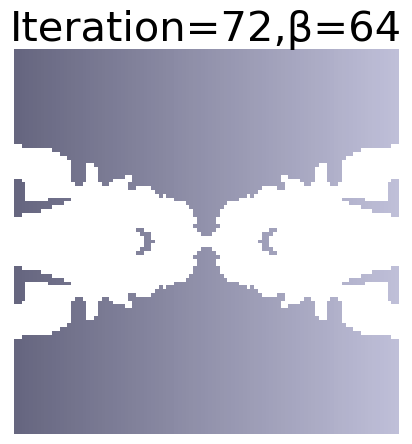

[0.54052562 0.52930806 0.52473895 ... 0.52473895 0.52930806 0.54052562]
2
0.5
64
[0.54049576 0.52927118 0.5246848  ... 0.5246848  0.52927118 0.54049576]


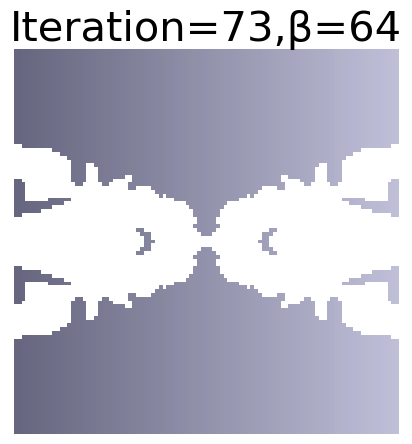

[0.54052561 0.52930805 0.52473894 ... 0.52473894 0.52930805 0.54052561]
2
0.5
64
[0.54049576 0.52927118 0.5246848  ... 0.5246848  0.52927118 0.54049576]


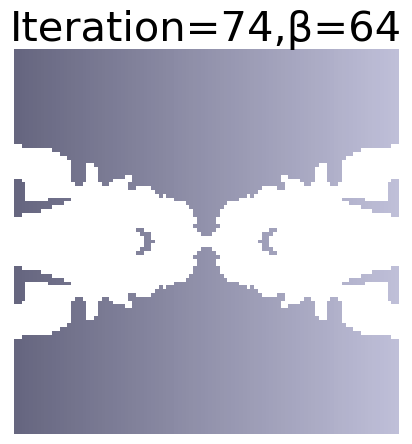

[0.54052561 0.52930805 0.52473894 ... 0.52473894 0.52930805 0.54052561]
2
0.5
64
[0.54049576 0.52927118 0.5246848  ... 0.5246848  0.52927118 0.54049576]


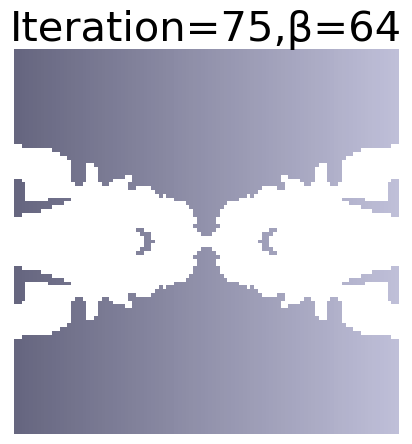

[0.54052561 0.52930805 0.52473894 ... 0.52473894 0.52930805 0.54052561]
2
0.5
128
[0.54052561 0.52930805 0.52473894 ... 0.52473894 0.52930805 0.54052561]


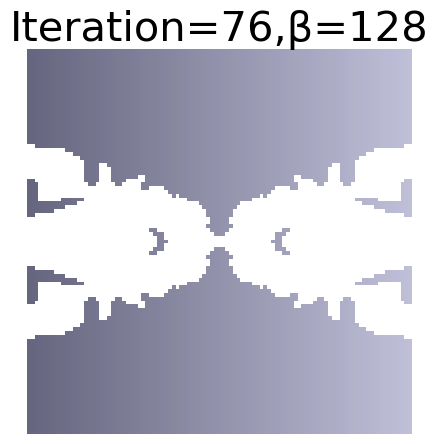

[0.54058866 0.52946062 0.52507105 ... 0.52507105 0.52946062 0.54058866]
2
0.5
128
[0.54052561 0.52930805 0.52473894 ... 0.52473894 0.52930805 0.54052561]


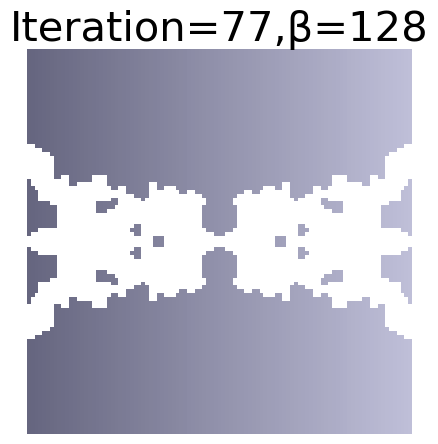

[0.54059472 0.52947483 0.52510114 ... 0.52510114 0.52947483 0.54059472]
2
0.5
128
[0.54052561 0.52930805 0.52473894 ... 0.52473894 0.52930805 0.54052561]


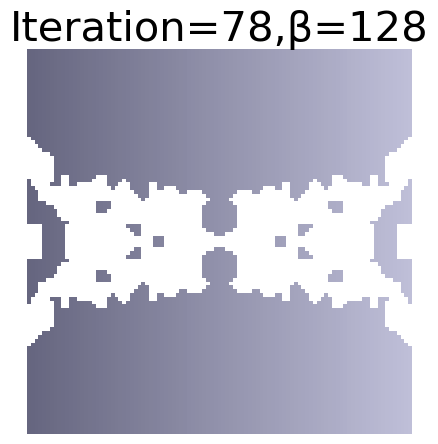

[0.54058926 0.52946204 0.52507406 ... 0.52507406 0.52946204 0.54058926]
2
0.5
128
[0.54052561 0.52930805 0.52473894 ... 0.52473894 0.52930805 0.54052561]


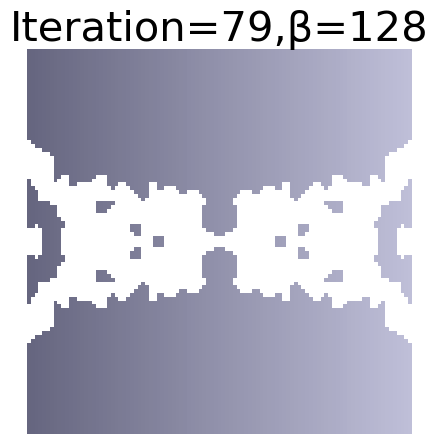

[0.54058879 0.52946092 0.5250717  ... 0.5250717  0.52946092 0.54058879]
2
0.5
128
[0.54052561 0.52930805 0.52473894 ... 0.52473894 0.52930805 0.54052561]


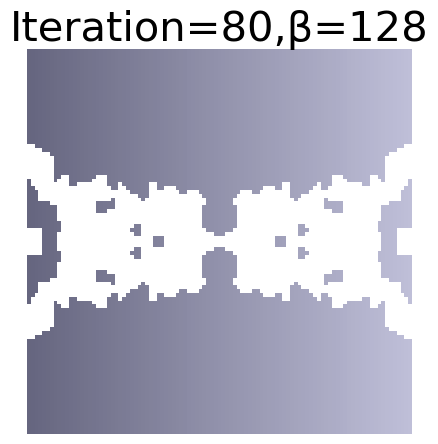

[0.5405887  0.52946071 0.52507126 ... 0.52507126 0.52946071 0.5405887 ]
2
0.5
128
[0.54052561 0.52930805 0.52473894 ... 0.52473894 0.52930805 0.54052561]


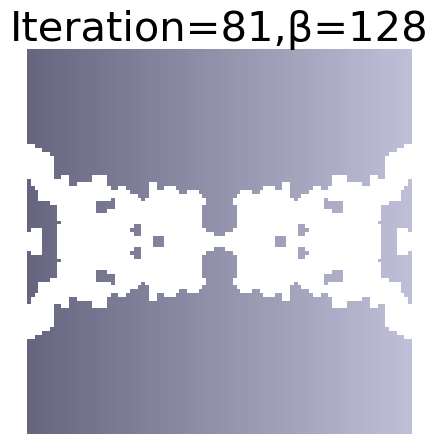

[0.54058867 0.52946065 0.52507113 ... 0.52507113 0.52946065 0.54058867]
2
0.5
128
[0.54052561 0.52930805 0.52473894 ... 0.52473894 0.52930805 0.54052561]


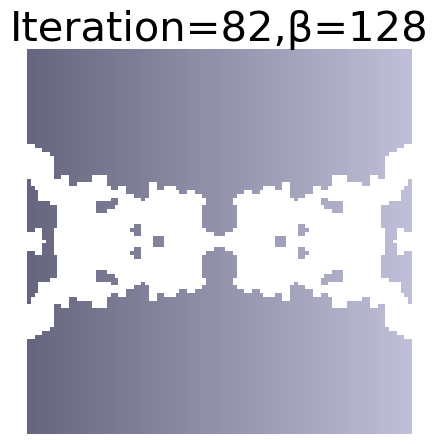

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
128
[0.54052561 0.52930805 0.52473894 ... 0.52473894 0.52930805 0.54052561]


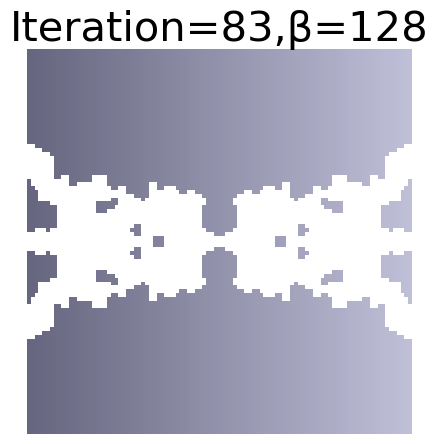

[0.54058867 0.52946064 0.5250711  ... 0.5250711  0.52946064 0.54058867]
2
0.5
128
[0.54052561 0.52930805 0.52473894 ... 0.52473894 0.52930805 0.54052561]


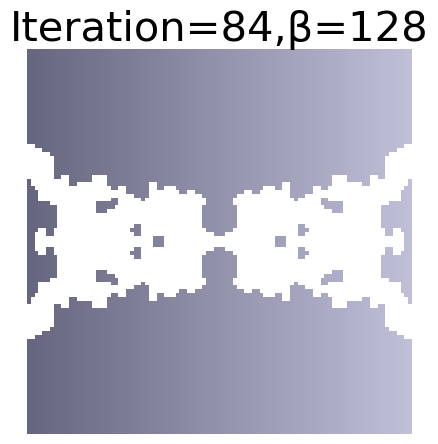

[0.54058866 0.52946064 0.52507109 ... 0.52507109 0.52946064 0.54058866]
2
0.5
128
[0.54052561 0.52930805 0.52473894 ... 0.52473894 0.52930805 0.54052561]


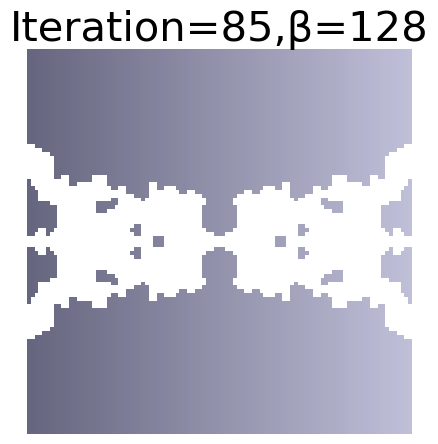

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
128
[0.54052561 0.52930805 0.52473894 ... 0.52473894 0.52930805 0.54052561]


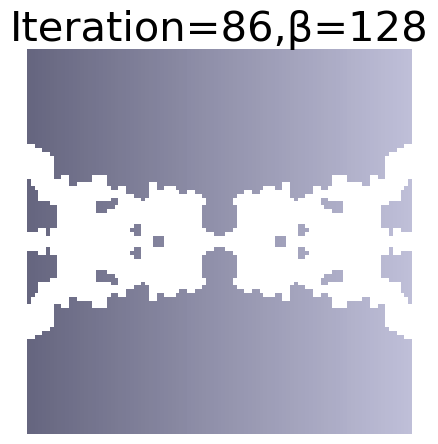

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
128
[0.54052561 0.52930805 0.52473894 ... 0.52473894 0.52930805 0.54052561]


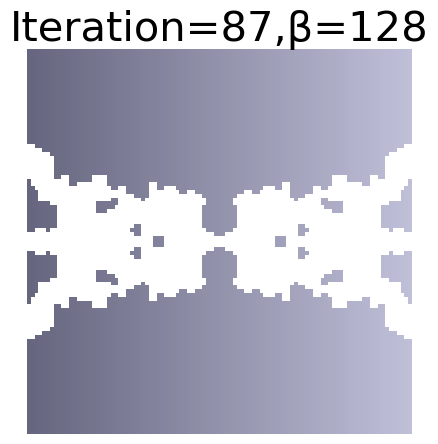

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
128
[0.54052561 0.52930805 0.52473894 ... 0.52473894 0.52930805 0.54052561]


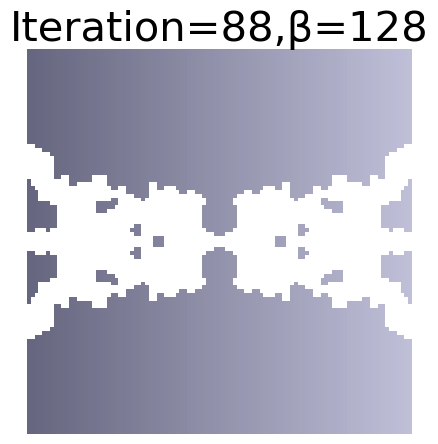

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
128
[0.54052561 0.52930805 0.52473894 ... 0.52473894 0.52930805 0.54052561]


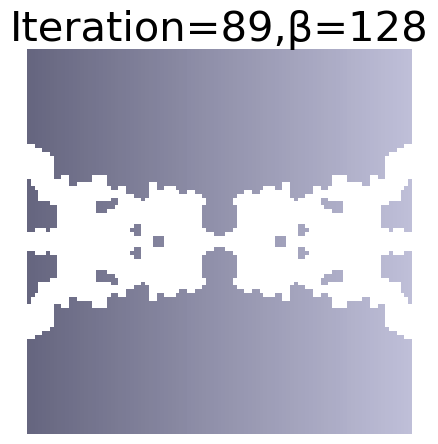

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
128
[0.54052561 0.52930805 0.52473894 ... 0.52473894 0.52930805 0.54052561]


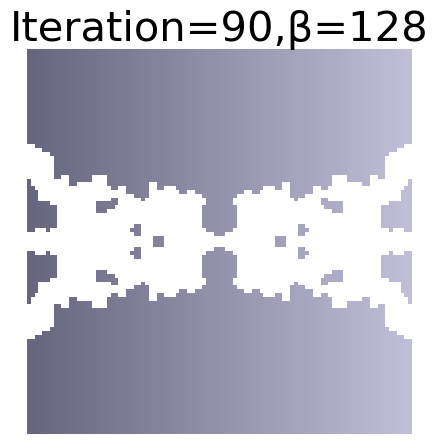

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
256
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


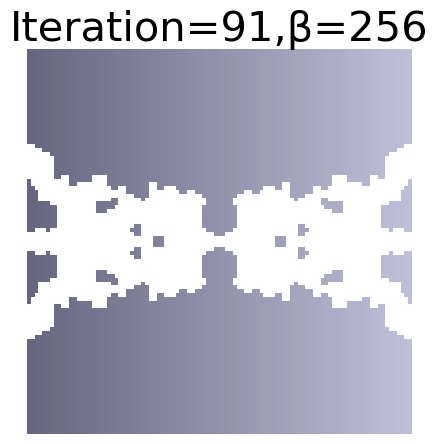

[0.54058875 0.52946122 0.52507302 ... 0.52507302 0.52946122 0.54058875]
2
0.5
256
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


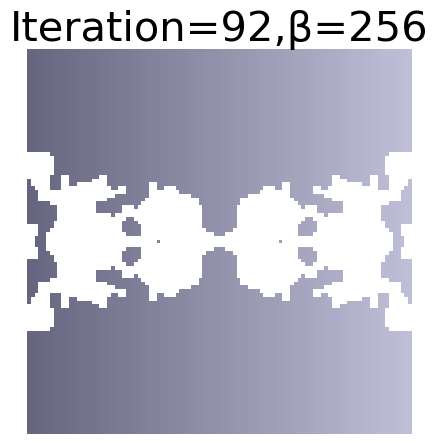

[0.54058867 0.52946069 0.52507128 ... 0.52507128 0.52946069 0.54058867]
2
0.5
256
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


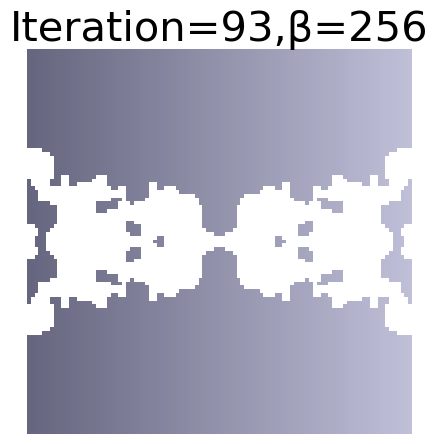

[0.54058866 0.52946064 0.52507111 ... 0.52507111 0.52946064 0.54058866]
2
0.5
256
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


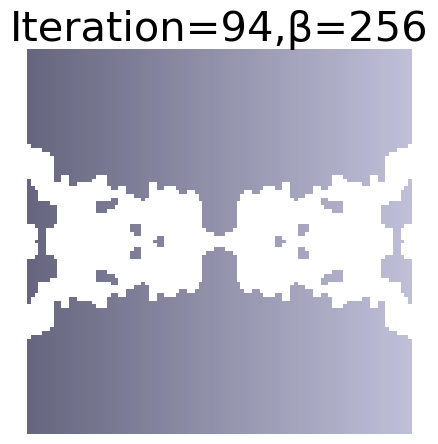

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
256
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


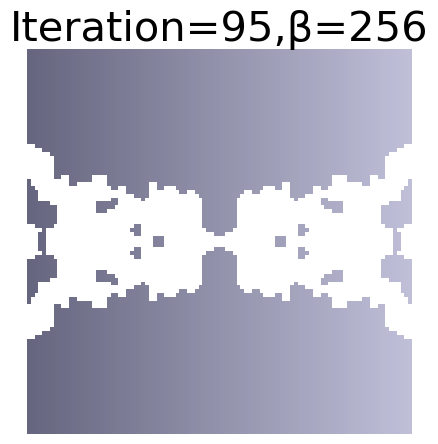

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
256
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


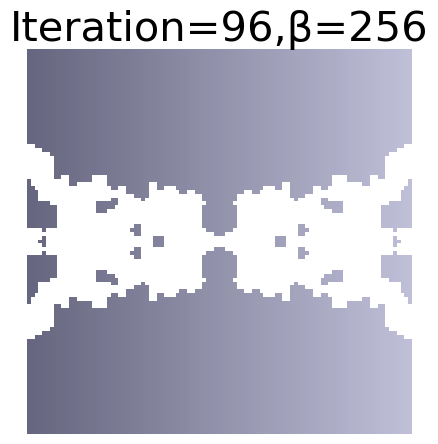

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
256
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


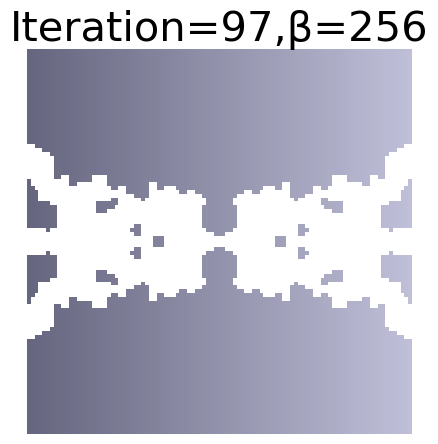

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
256
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


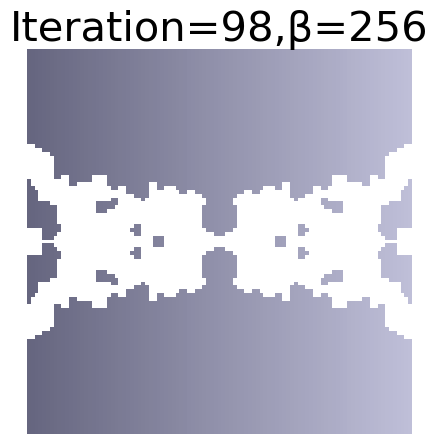

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
256
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


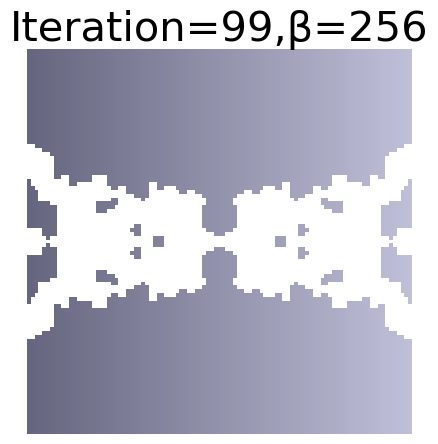

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
256
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


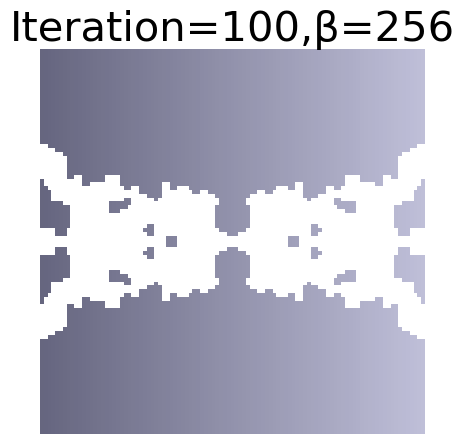

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
256
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


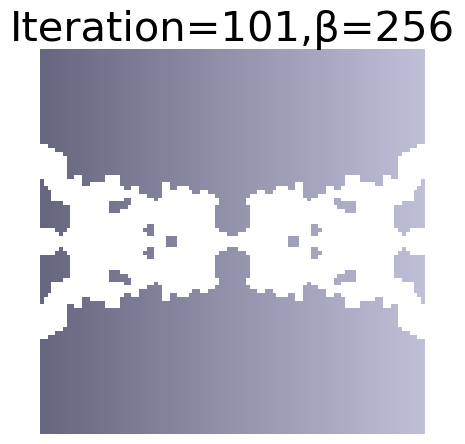

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
256
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


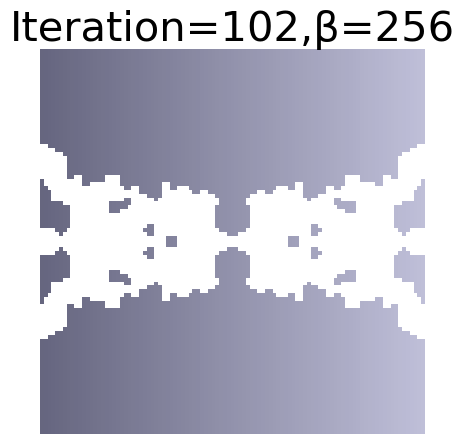

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
256
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


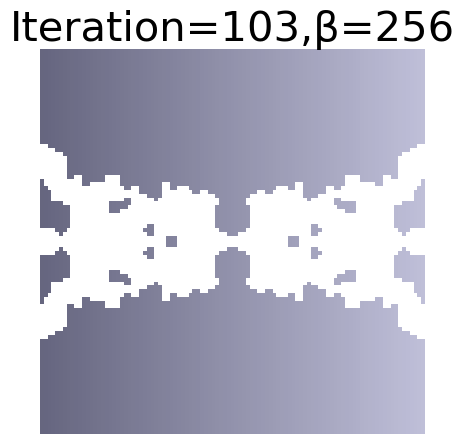

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
256
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


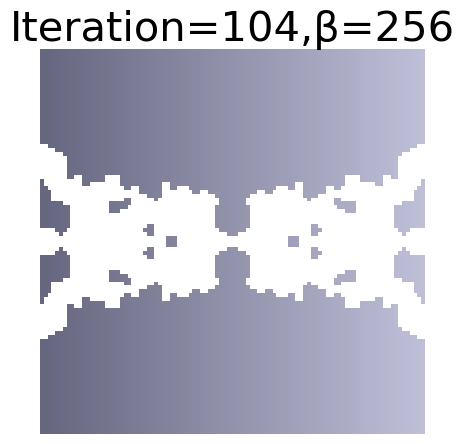

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
256
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


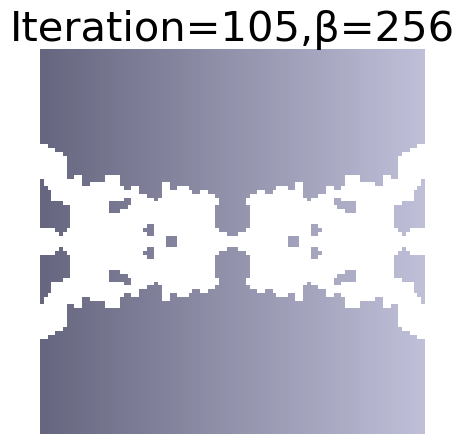

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
512
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


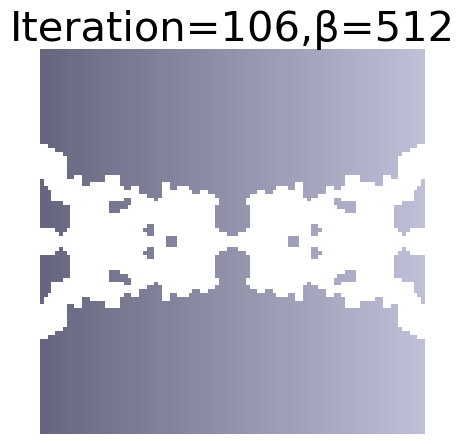

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
512
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


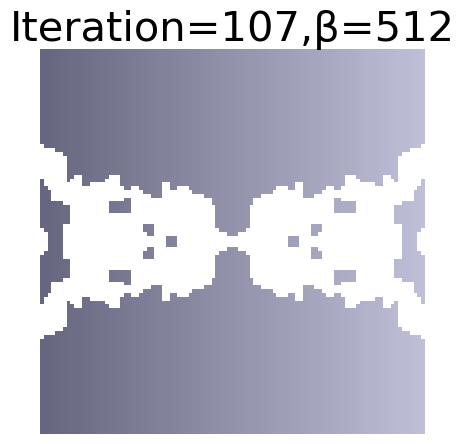

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
512
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


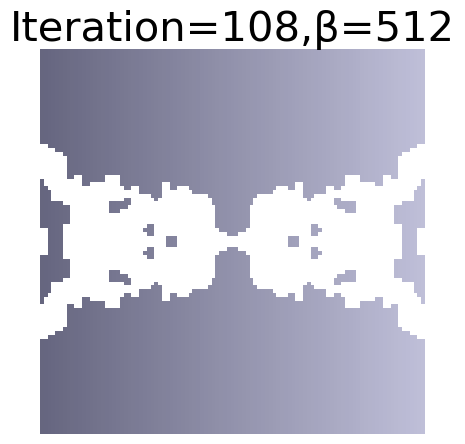

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
512
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


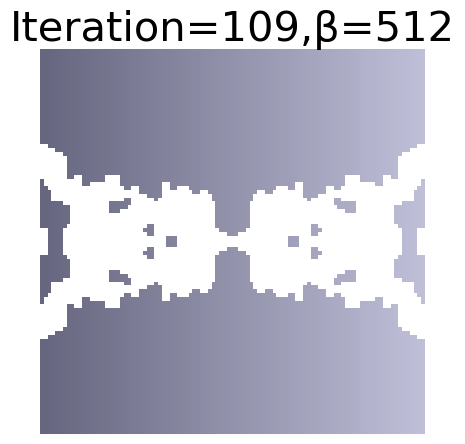

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
512
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


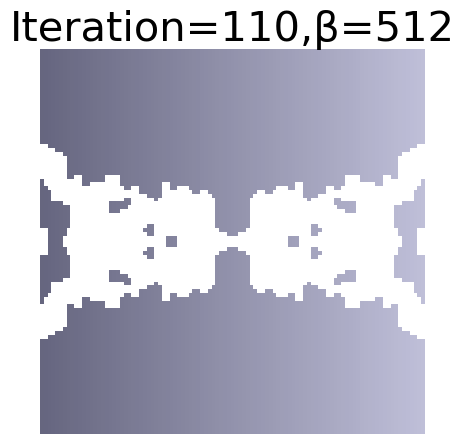

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
512
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


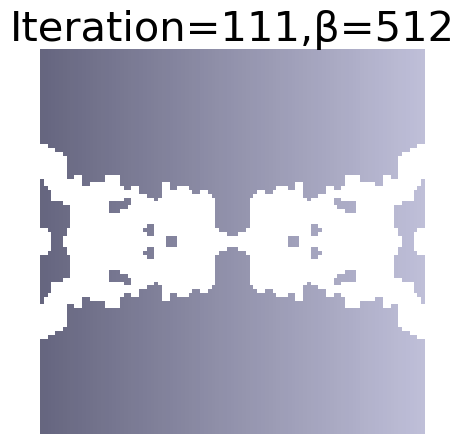

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
512
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


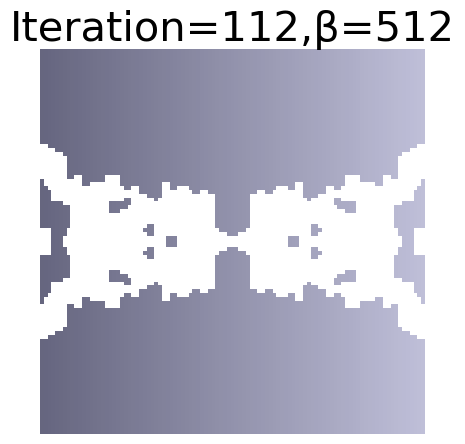

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
512
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


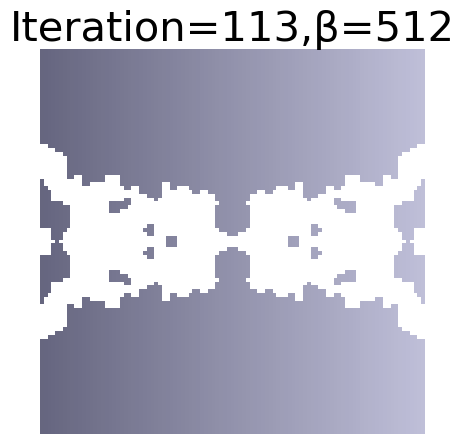

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
512
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


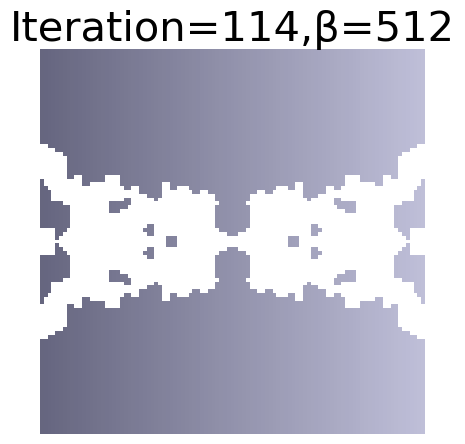

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
512
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


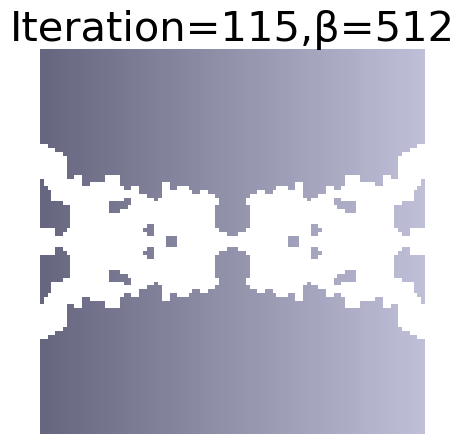

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
512
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


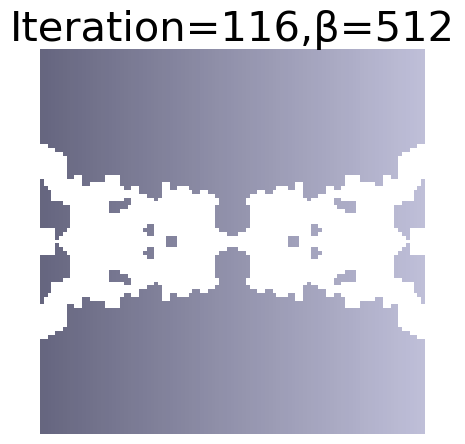

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
512
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


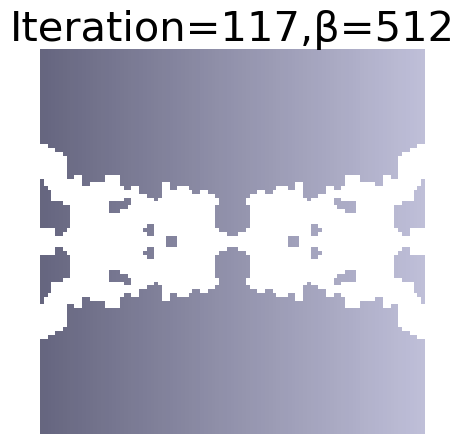

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
512
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


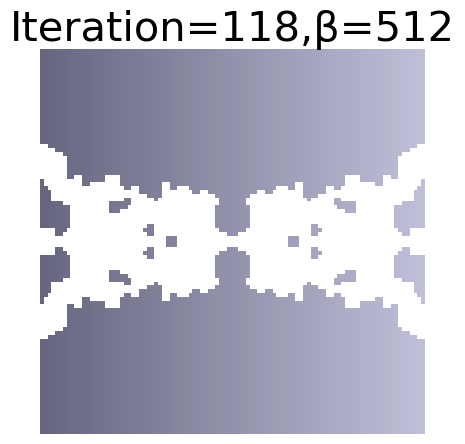

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
512
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


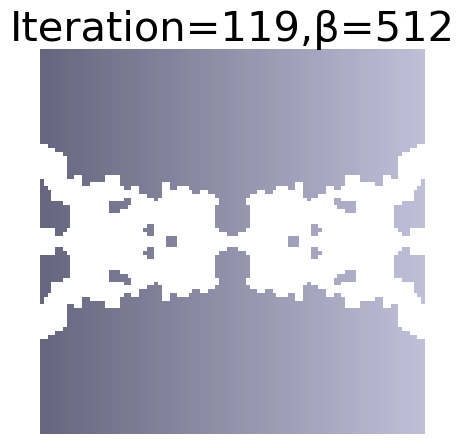

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
512
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


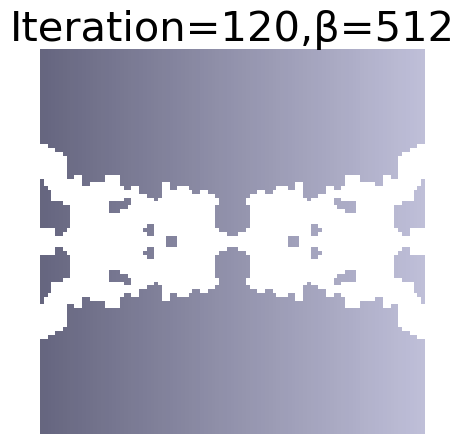

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
1024
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


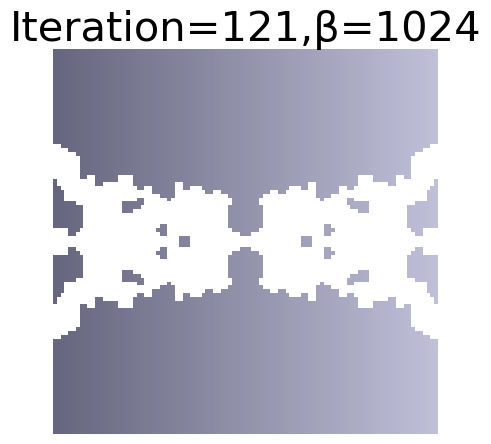

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
1024
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


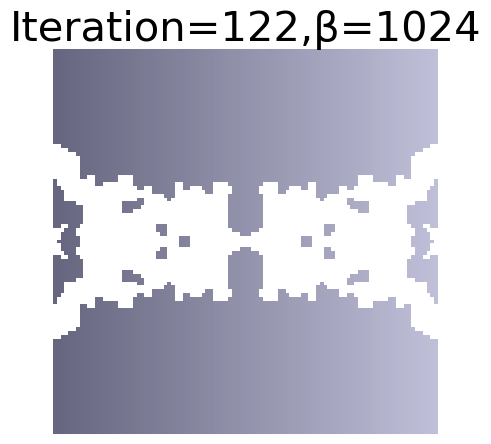

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
1024
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


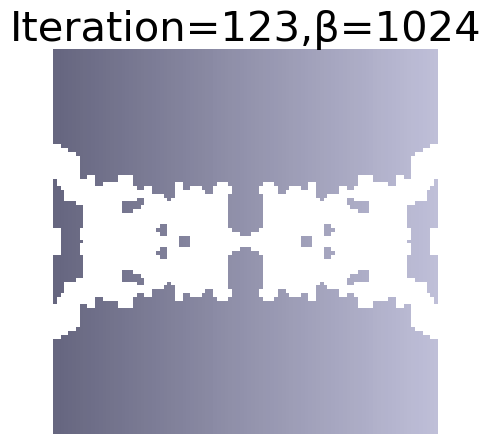

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
1024
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


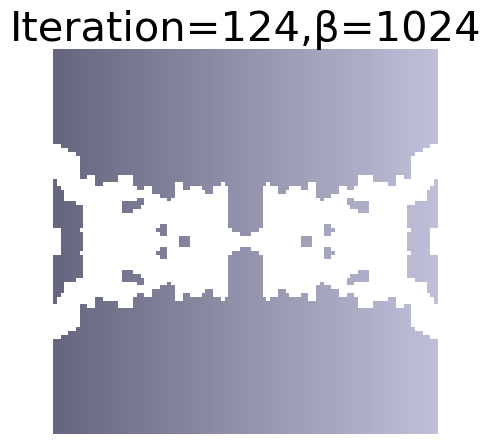

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
1024
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


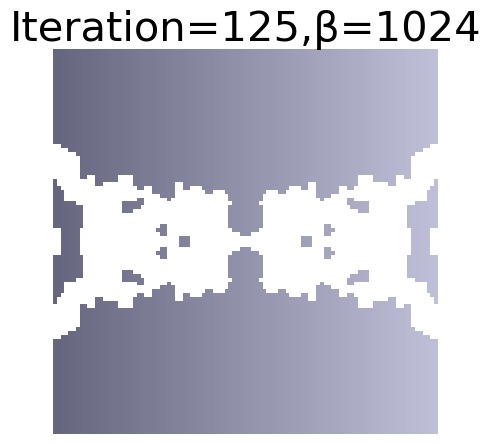

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
1024
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


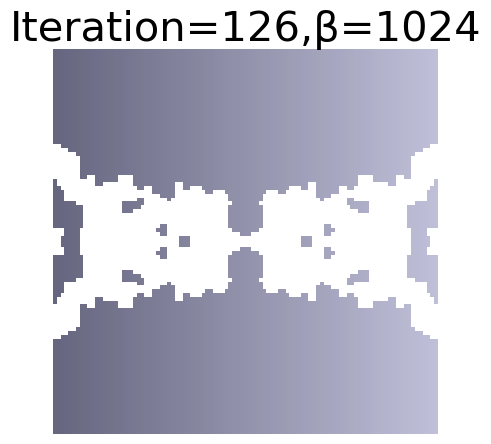

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
1024
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


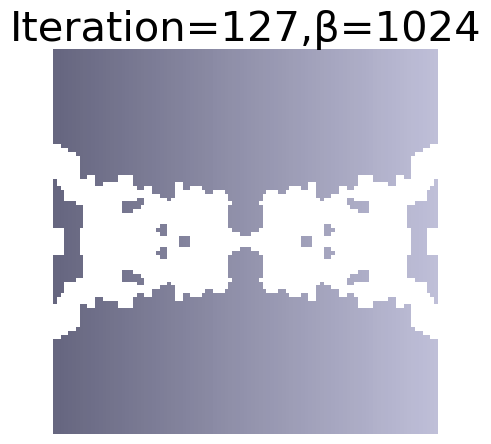

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
1024
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


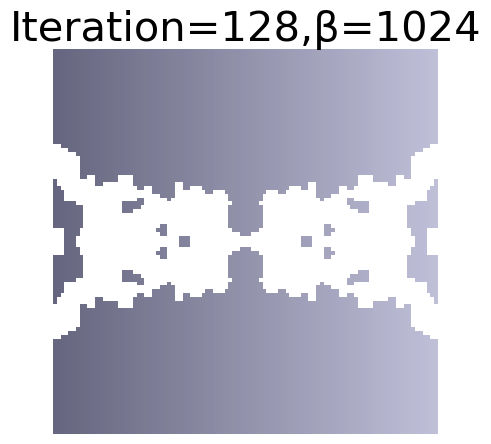

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
1024
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


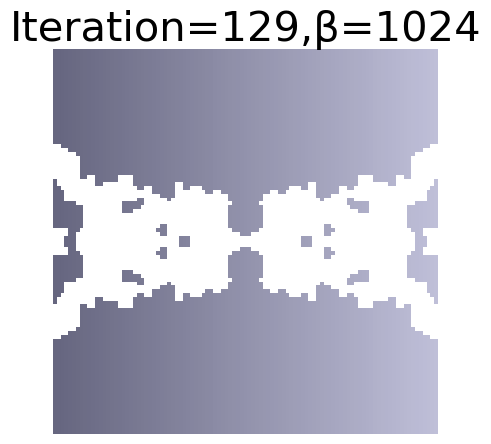

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
1024
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


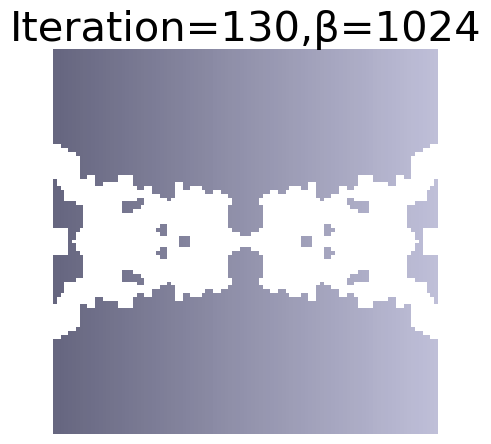

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
1024
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


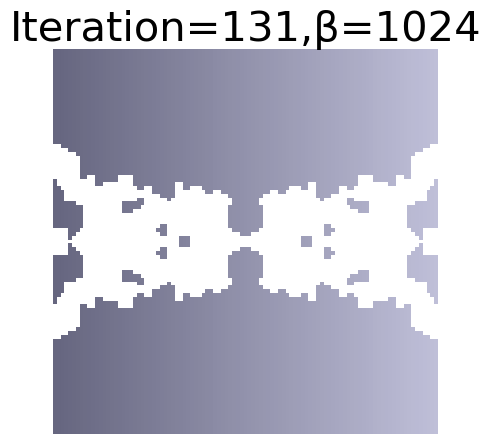

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
1024
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


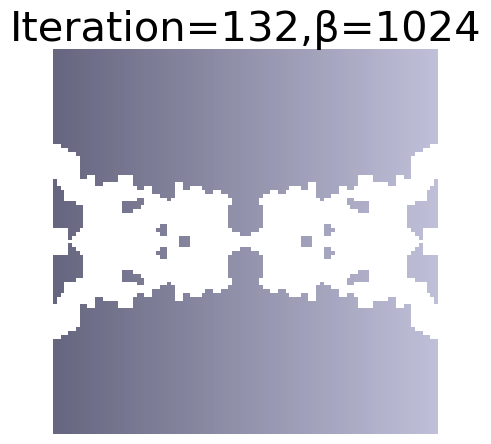

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
1024
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


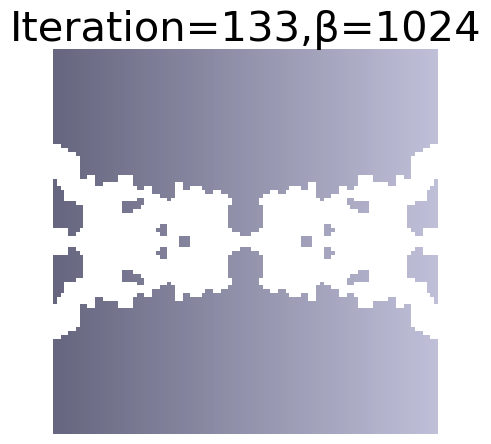

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
1024
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


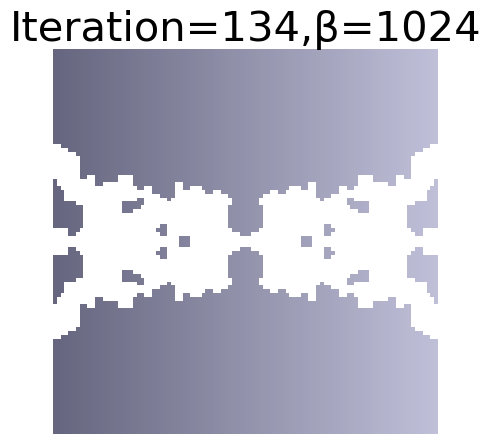

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
1024
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


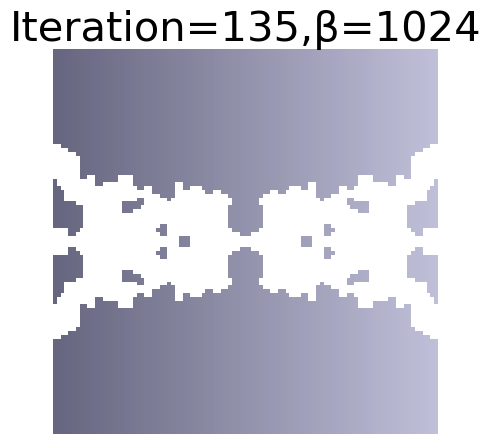

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
2048
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


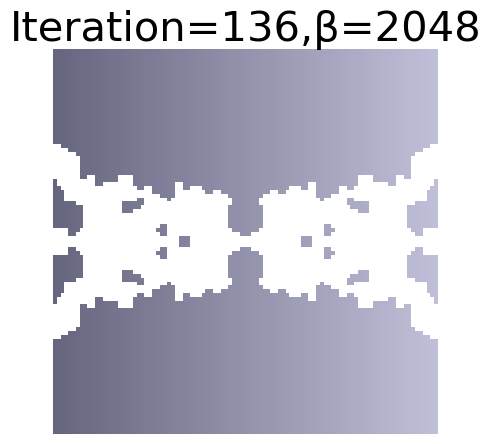

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
2048
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


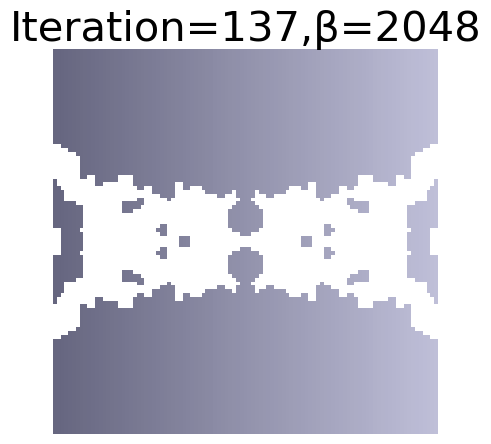

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
2048
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


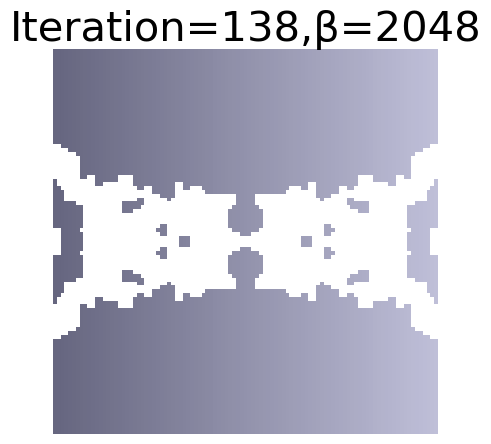

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
2048
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


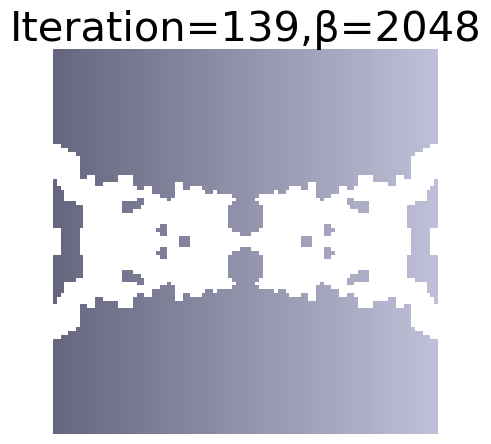

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
2048
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


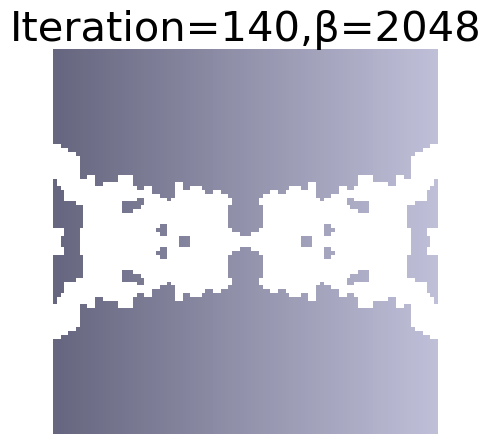

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
2048
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


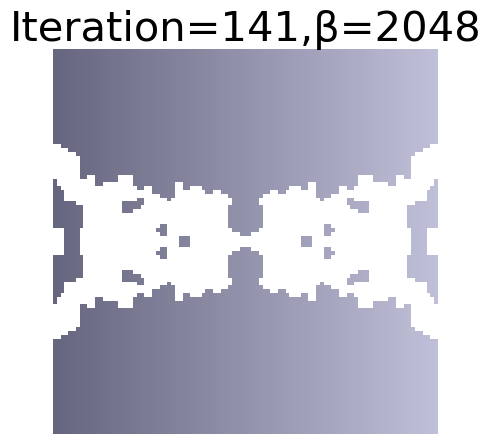

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
2048
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


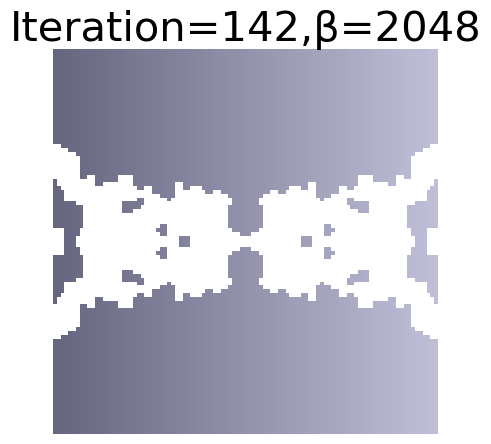

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
2048
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


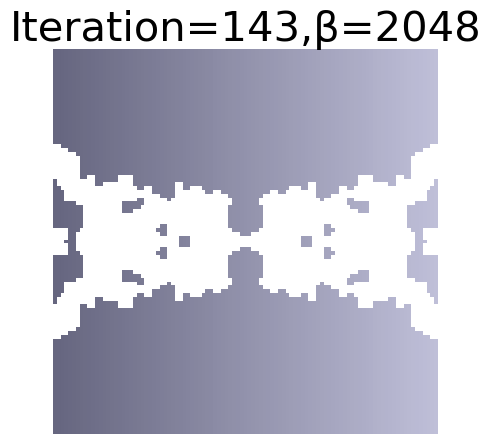

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
2048
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


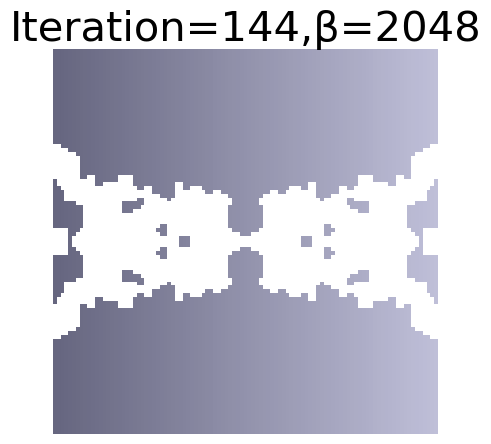

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
2048
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


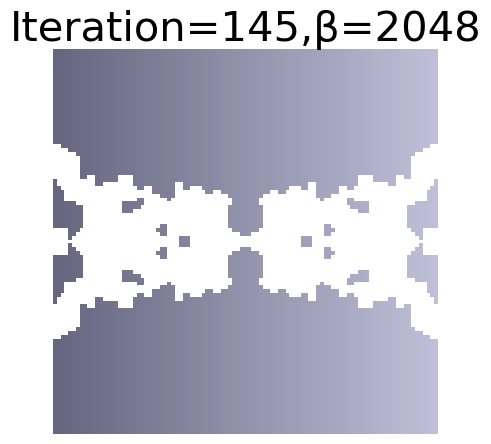

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
2048
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


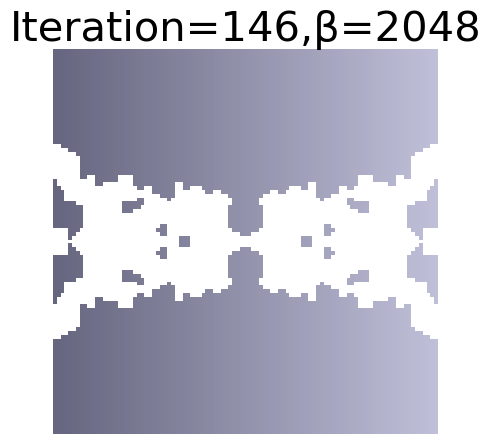

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
2048
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


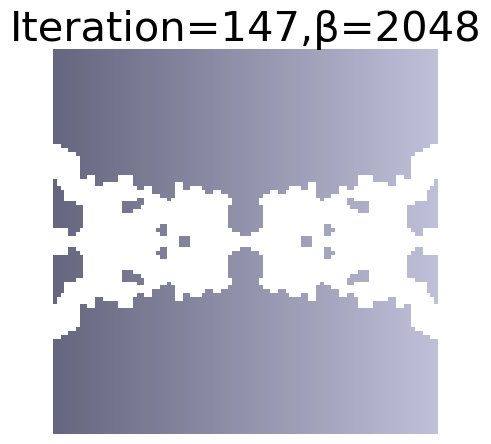

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
2048
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


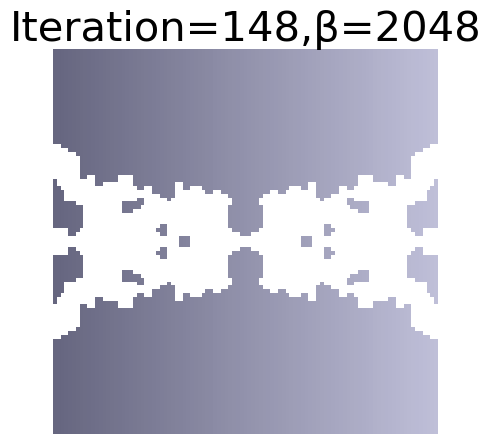

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
2048
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


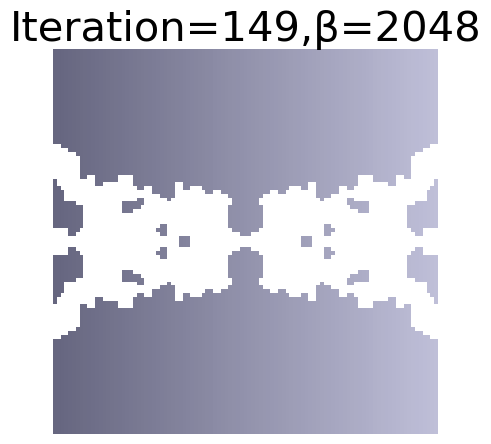

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
2048
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


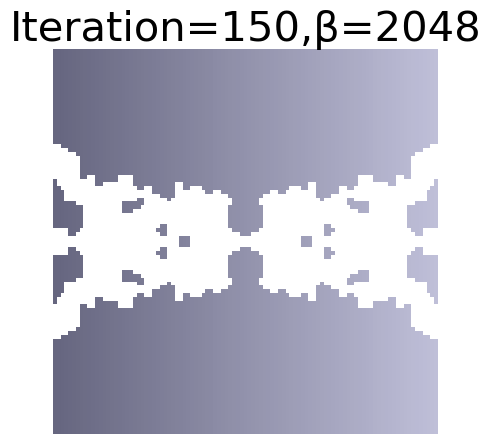

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
4096
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


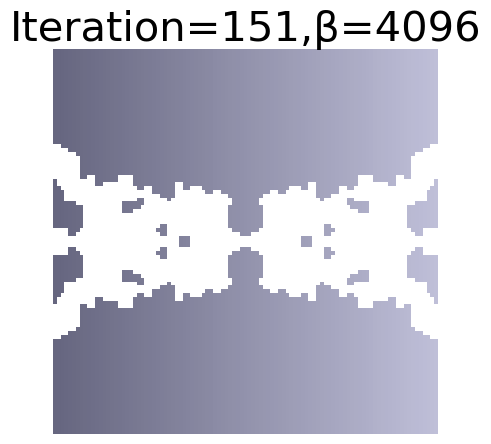

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
4096
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


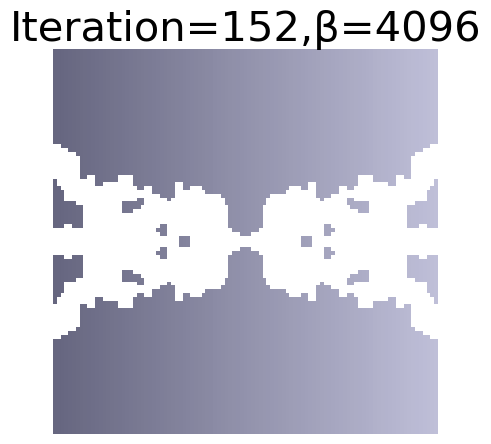

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
4096
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


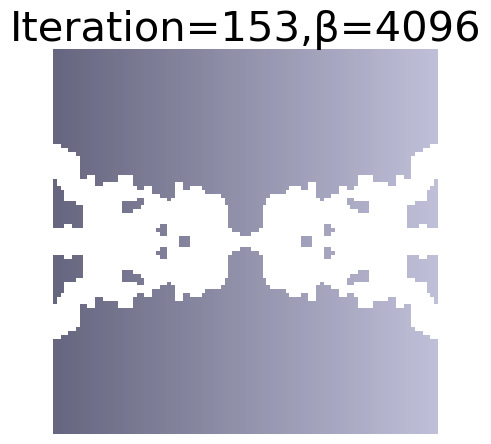

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
4096
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


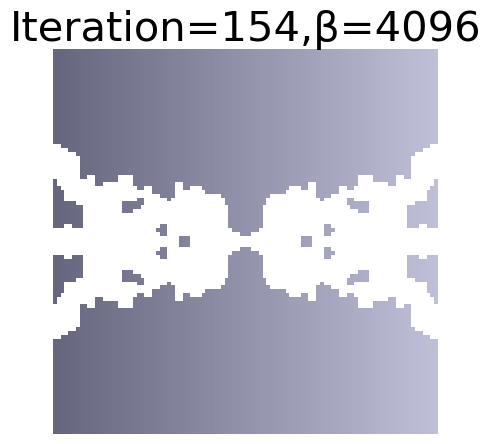

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
8192
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


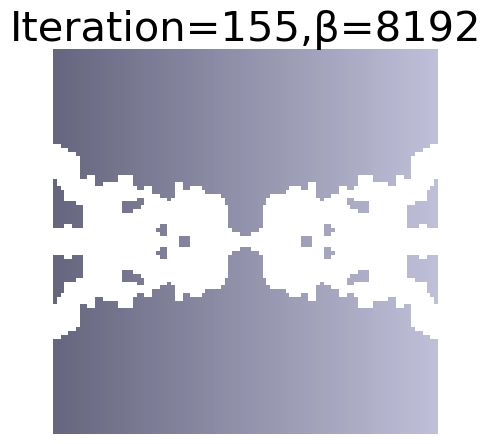

[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]
2
0.5
8192
[0.54058866 0.52946063 0.52507109 ... 0.52507109 0.52946063 0.54058866]


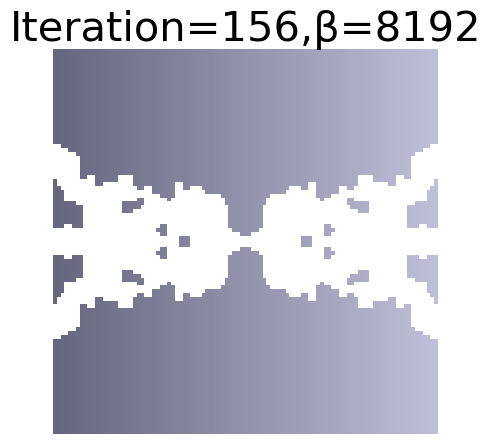

FileNotFoundError: [Errno 2] No such file or directory: 'Post_v_array157.npy'

In [3]:
for i in range(1,180):
    v_array = np.load(f'Post_v_array{i:03d}.npy')
    print(v_array)
    beta_A = np.load(f'Post_beta_scale_array{i:03d}.npy')
    print(beta_A)
    eta_A = np.load(f'Post_eta_i_array{i:03d}.npy')
    print(eta_A)
    cur_A = np.load(f'Post_cur_beta_array{i:03d}.npy')
    print(cur_A)
    x_A = np.load(f'Post_x_array{i:03d}.npy')
    print(x_A)
    


    opt.update_design([mapping(v_array, eta_A, cur_A/beta_A)]) # cur_beta/beta_scale is the final beta in the optimization.


    
    cool_silver_cmap = LinearSegmentedColormap.from_list(
    "cool_silver", [
        (0.0, (0.4, 0.4, 0.5)),
        (0.4, (0.75, 0.75, 0.85)),
        (0.7, (0.95, 0.95, 1.0)),
        (1.0, (0.8, 0.8, 0.9)),
    ]
    )
    design_array = mapping(v_array, eta_A, cur_A / beta_A)
    design_array = design_array.reshape((design_region_resolution + 1, design_region_resolution + 1)).T

    gradient = np.linspace(0, 0.4, design_array.shape[1])
    gradient_2d = np.tile(gradient, (design_array.shape[0], 1))
    
    cool_silver_rgb = cool_silver_cmap(gradient_2d)[..., :3] 
    final_image = np.ones((*design_array.shape, 3))
    mask = design_array > 0.5
    final_image[mask] = cool_silver_rgb[mask]
    
    
    
    
    
    plt.figure(figsize=(5, 5))
    plt.title(f"Iteration={i :d},β={cur_A}", fontsize=30)
    ax = plt.gca()
    ax.imshow(final_image, origin='lower')
    ax.axis("off")

    circ = Circle((2, 2), minimum_length / 2)
    ax.add_patch(circ)
    ax.axis("off")
    plt.savefig(f'PICTURE/Picture{i:03d}.png')
    plt.show()


    

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image

# Set the directory where your images are stored
image_folder = "PICTURE"
image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(".png")])  # Adjust for JPG, etc.

# Load images using PIL
images = [Image.open(img) for img in image_files]

# Create figure and axis
fig, ax = plt.subplots()
ax.axis("off")  # Hide axis
im = ax.imshow(images[0])  # Initialize with the first image

# Animation function
def update(frame):
    im.set_array(images[frame])
    return [im]

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(images), interval=200, blit=True)
plt.close(fig)
# Display in Jupyter Notebook
from IPython.display import HTML
HTML(ani.to_jshtml())


In [ ]:
# Convert images to GIF
output_gif = "animation.gif"

# Save images as an animated GIF
images[0].save(
    output_gif,
    save_all=True,
    append_images=images[1:],
    duration=200,  # 每幀持續時間 (毫秒)
    loop=0         # 0 表示無限循環
)

print(f"GIF 已儲存至 {output_gif}")